# Volatility Forecasting 

In [32]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
random_state=42
np.random.seed(42)
tf.random.set_seed(42)

svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [2]:
stocks = '^GSPC'
start = datetime.datetime(2015,1, 1)
end = datetime.datetime(2024,8, 23)
s_p500 = yf.download(stocks,start,end,interval='1d')
ret = 100*((s_p500['Adj Close']).pct_change()[1:])
realized_vol=ret.rolling(5).std()

[*********************100%%**********************]  1 of 1 completed


In [3]:
ret = 100*((s_p500['Adj Close']).pct_change()[1:])
realized_vol=ret.rolling(5).std()

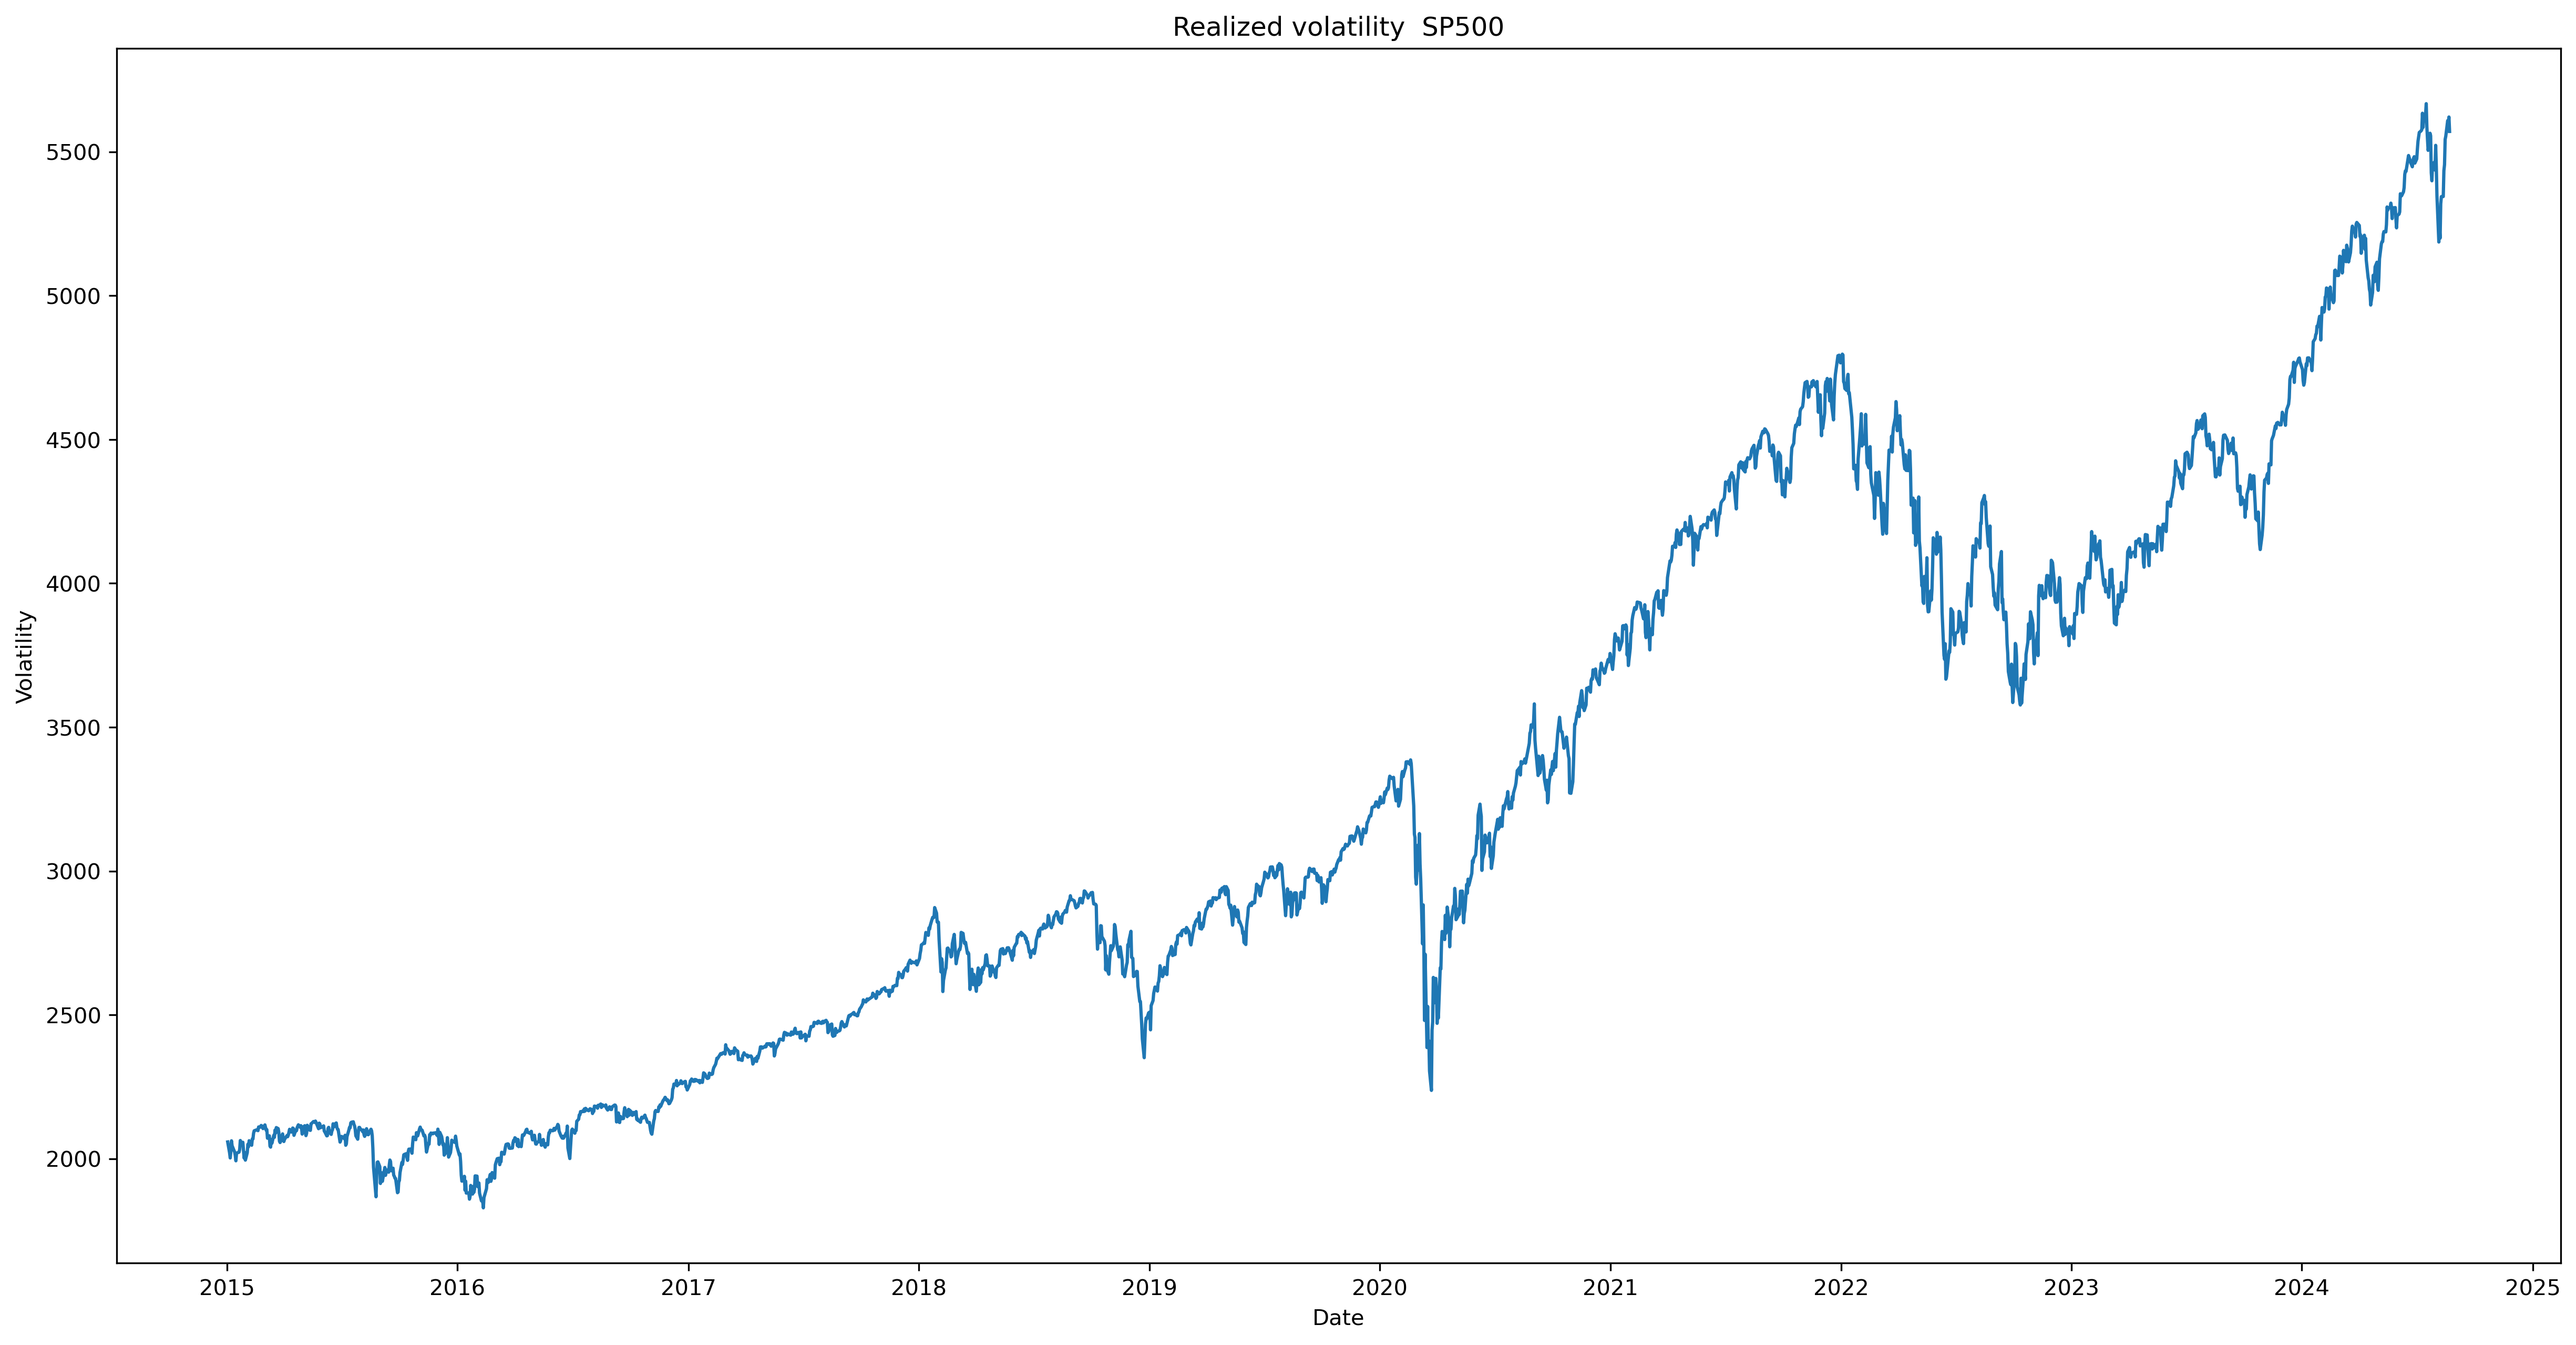

In [4]:
plt.figure(figsize=(20,10))
plt.plot(s_p500['Adj Close'].index,s_p500['Adj Close'])
plt.title('Realized volatility  SP500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

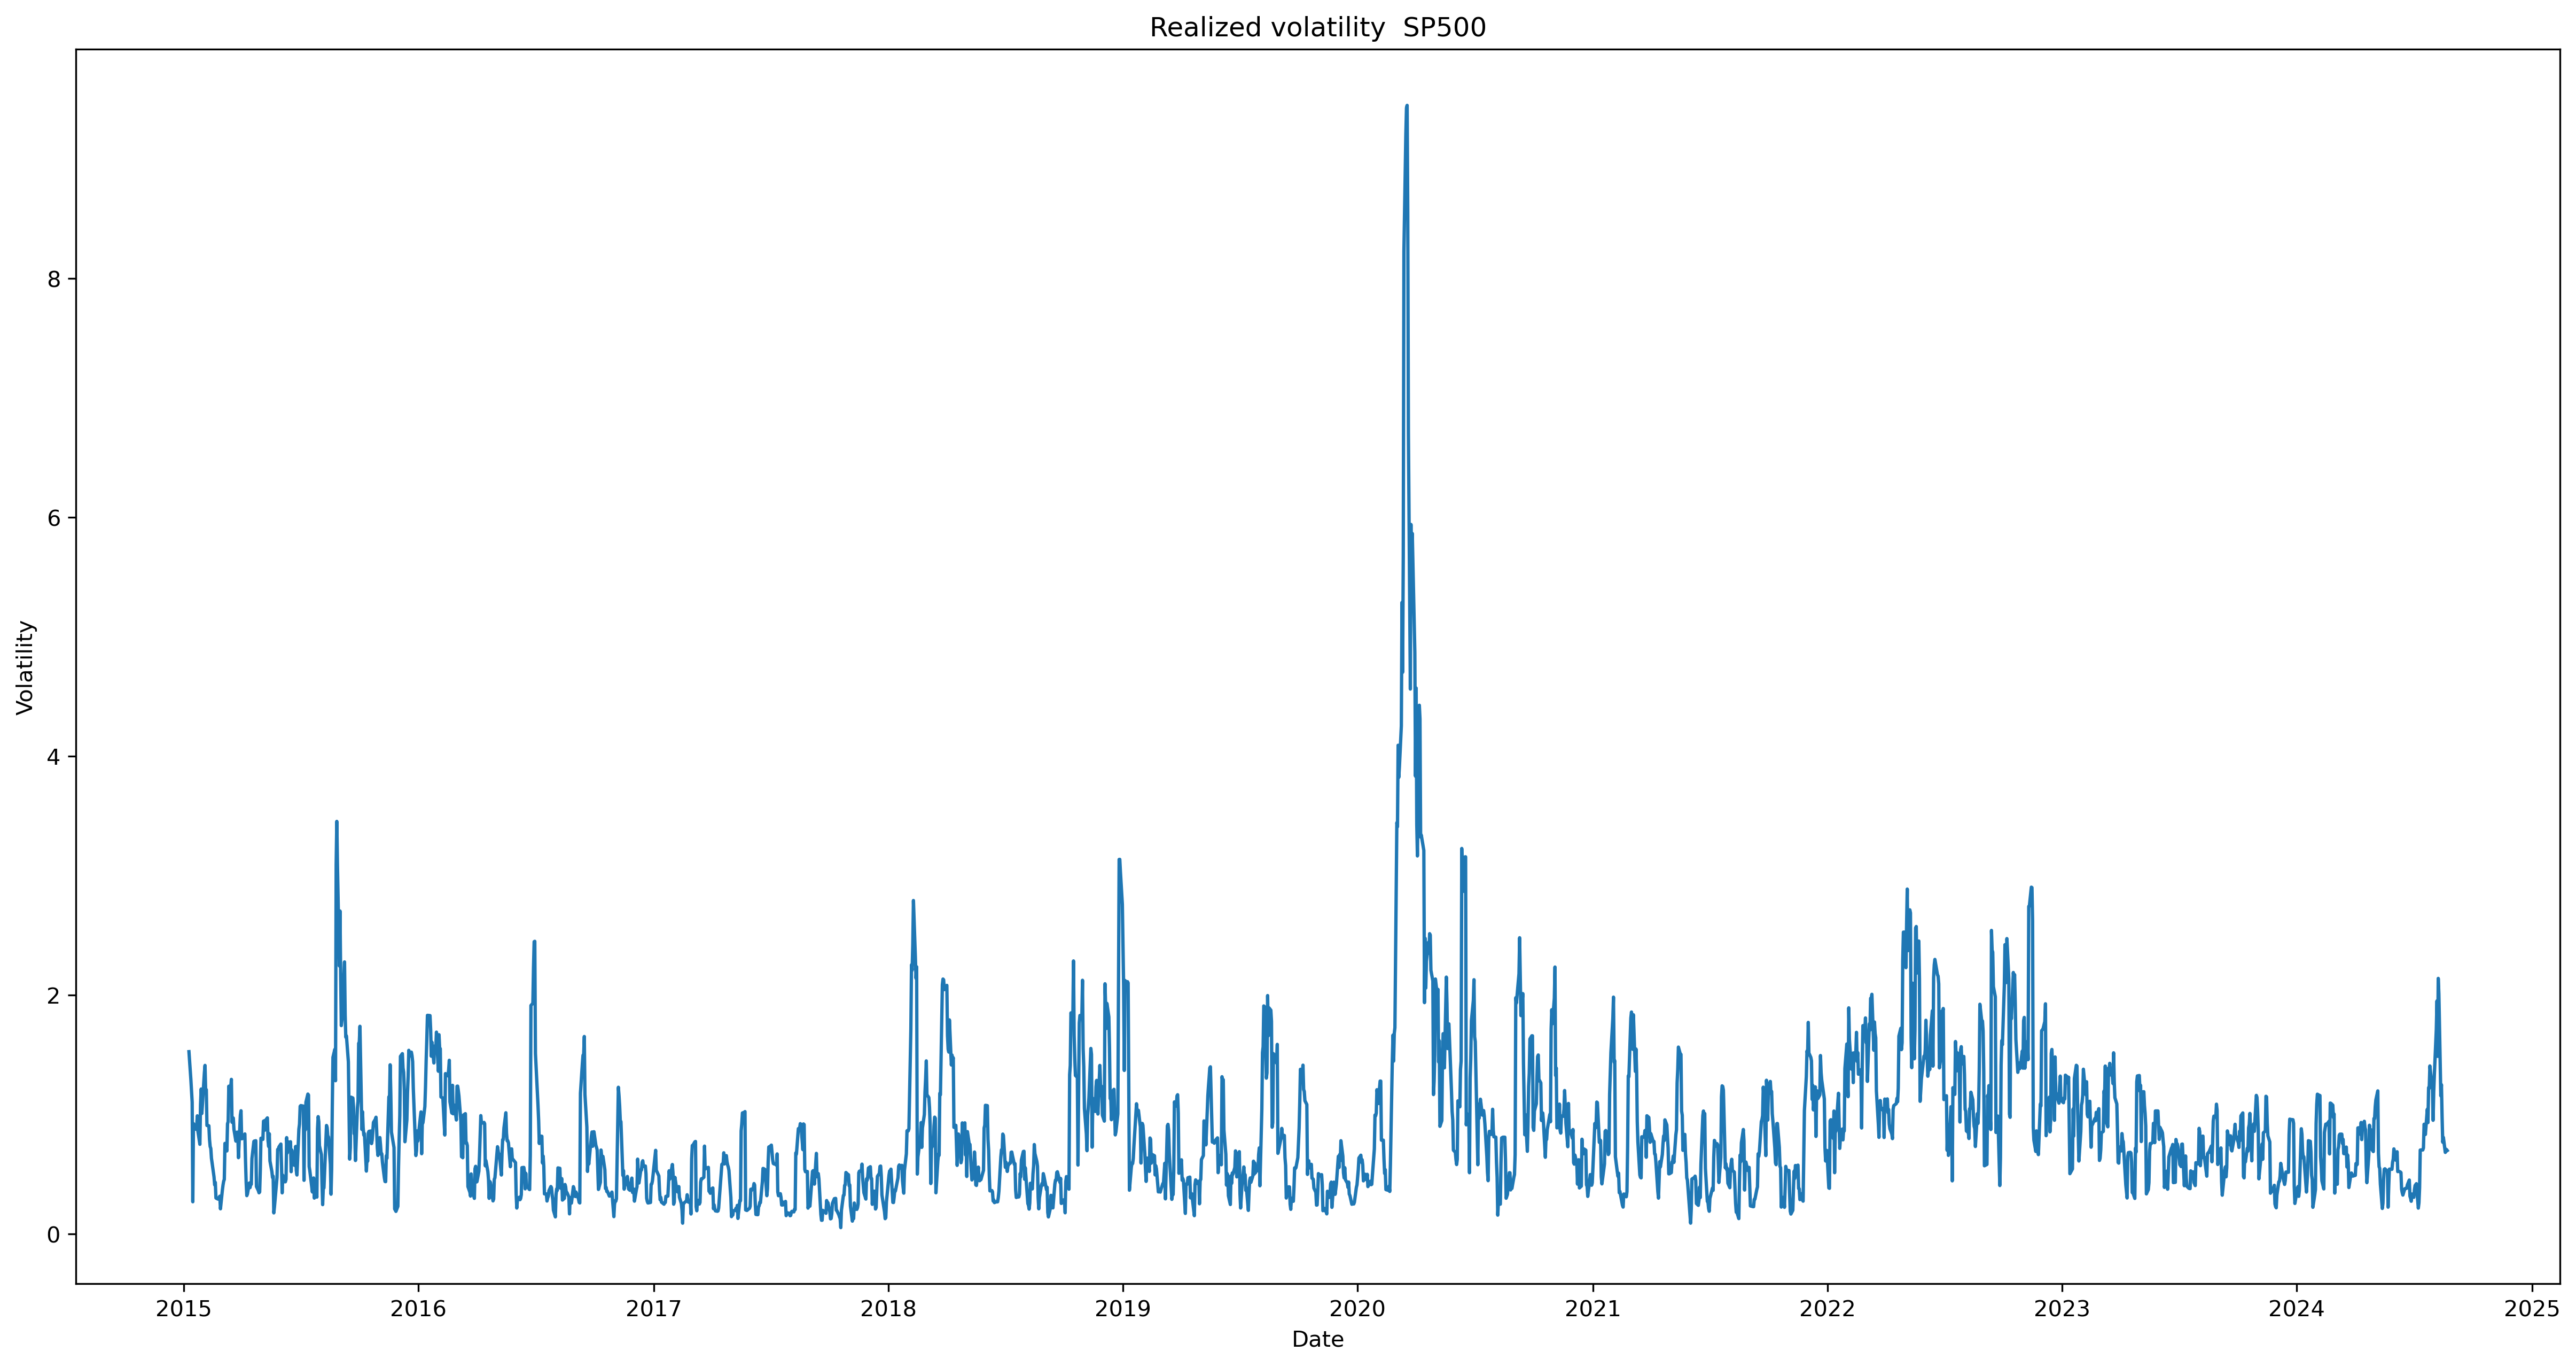

In [5]:
plt.figure(figsize=(20,10))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized volatility  SP500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

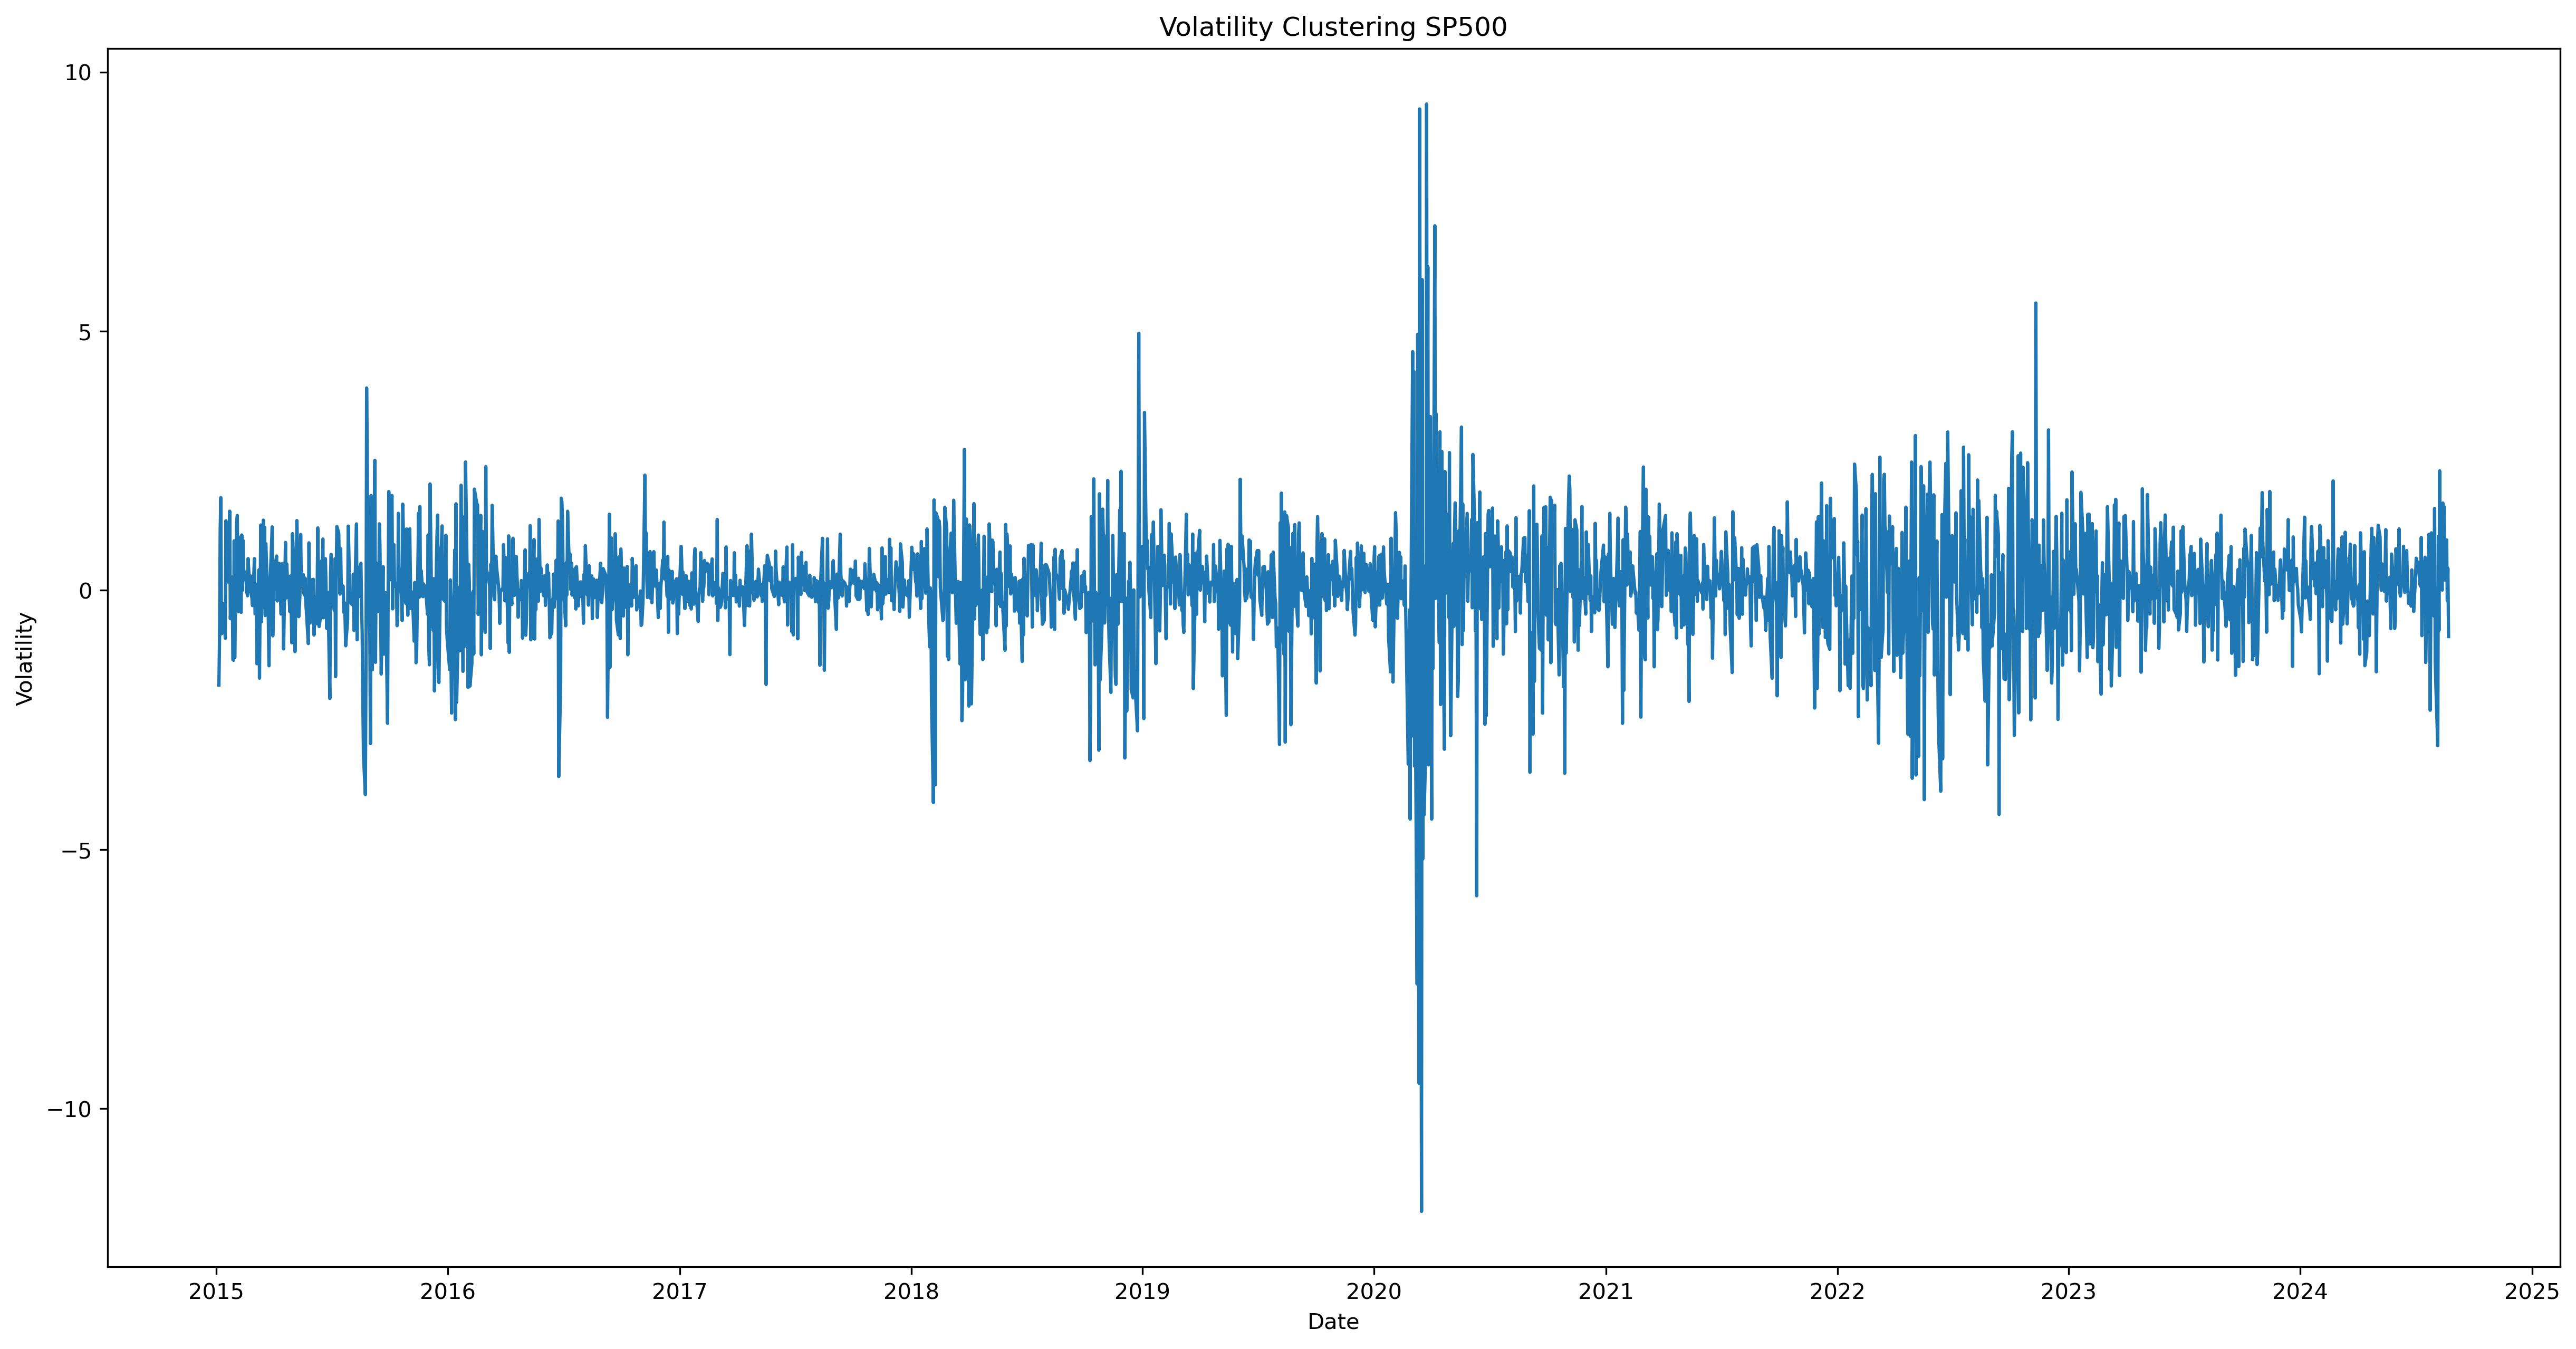

In [6]:
plt.figure(figsize=(20,10))
plt.plot(ret.index,ret)
plt.title('Volatility Clustering SP500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

## Volatility Modeling 

### ARCH

In [7]:
n=252
split_date = ret.iloc[-n:].index
retv = ret.values

In [8]:
bic_arch = []

for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p

arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3177.37
Distribution:                  Normal   AIC:                           6364.74
Method:            Maximum Likelihood   BIC:                           6393.70
                                        No. Observations:                 2425
Date:                Wed, Aug 28 2024   Df Residuals:                     2425
Time:                        11:34:58   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2762  3.033e-02      9.107  8.496e-20   [  0.21

In [9]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, 
                        np.sqrt(forecast_arch\
                        .variance.iloc[-len(split_date):] 
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0808


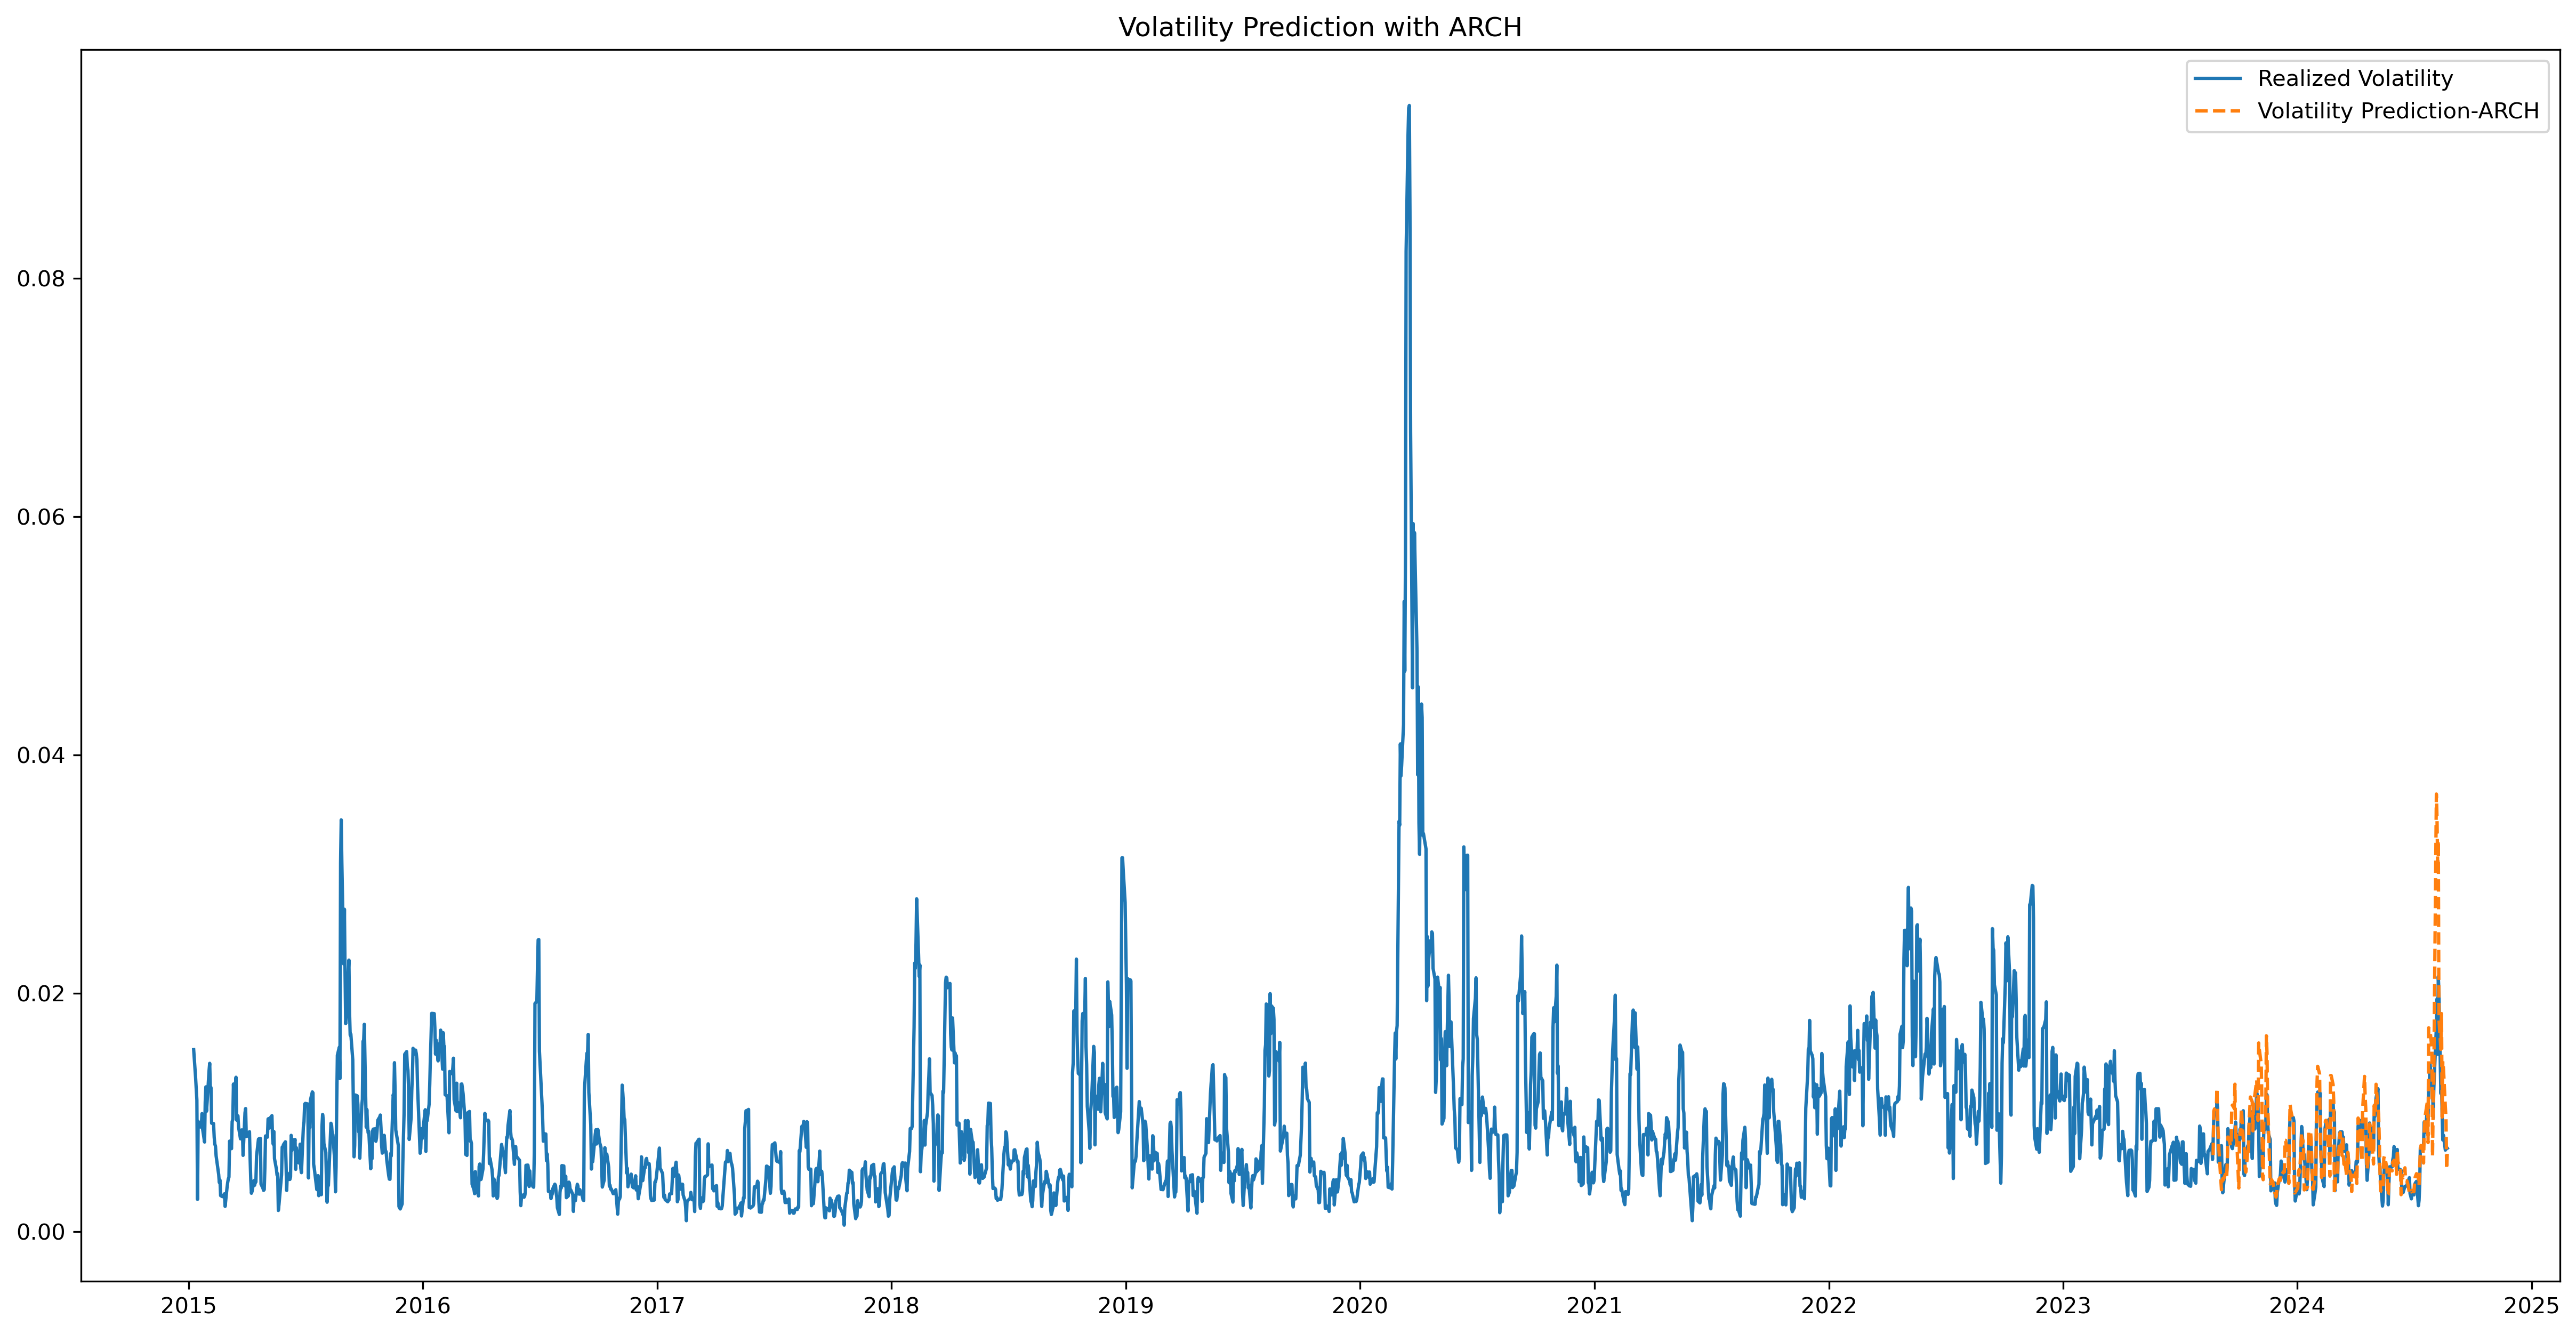

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-ARCH', linestyle='--')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

### GARCH

In [11]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3128.74
Distribution:                  Normal   AIC:                           6263.49
Method:            Maximum Likelihood   BIC:                           6280.87
                                        No. Observations:                 2425
Date:                Wed, Aug 28 2024   Df Residuals:                     2425
Time:                        11:36:04   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0357  9.864e-03      3.624  2.899e-04 [1.

In [12]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch\
                         .variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0766


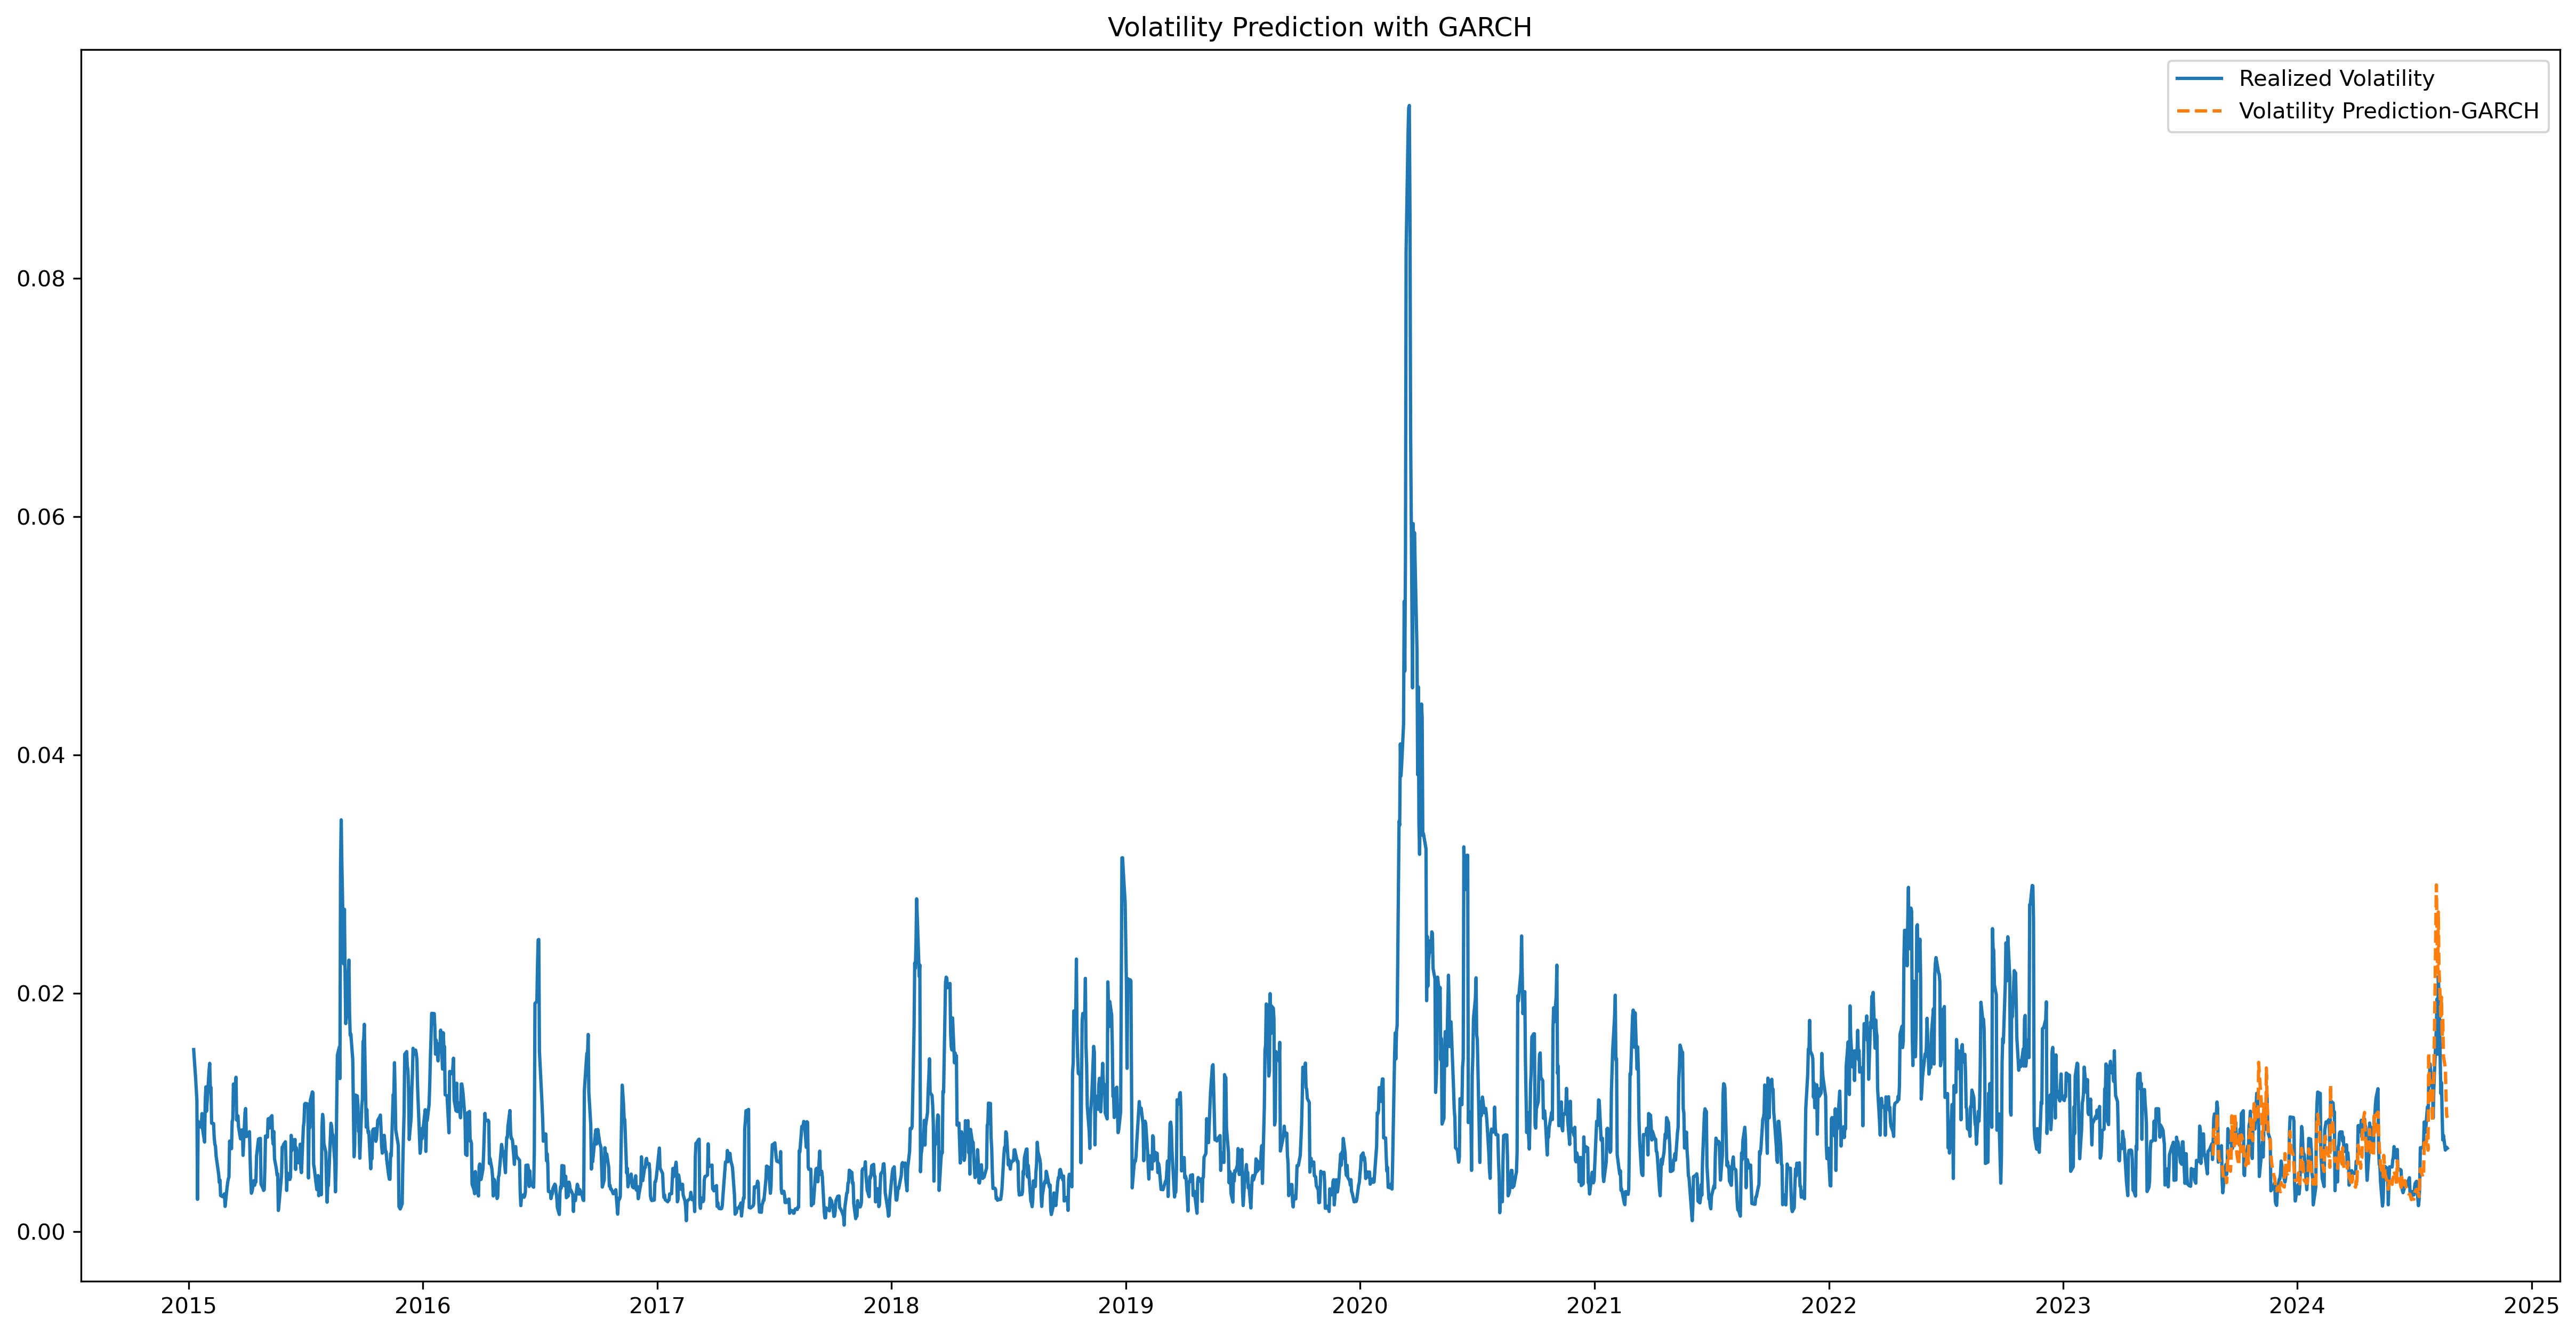

In [13]:
plt.figure(figsize=(20,10))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH', linestyle='--')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

### EGARCH

In [14]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
                 .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
         .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3143.85
Distribution:                  Normal   AIC:                           6293.69
Method:            Maximum Likelihood   BIC:                           6311.07
                                        No. Observations:                 2425
Date:                Wed, Aug 28 2024   Df Residuals:                     2425
Time:                        11:36:21   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.9618e-03  7.007e-03      0.565      0.572 

In [15]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance\
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0794


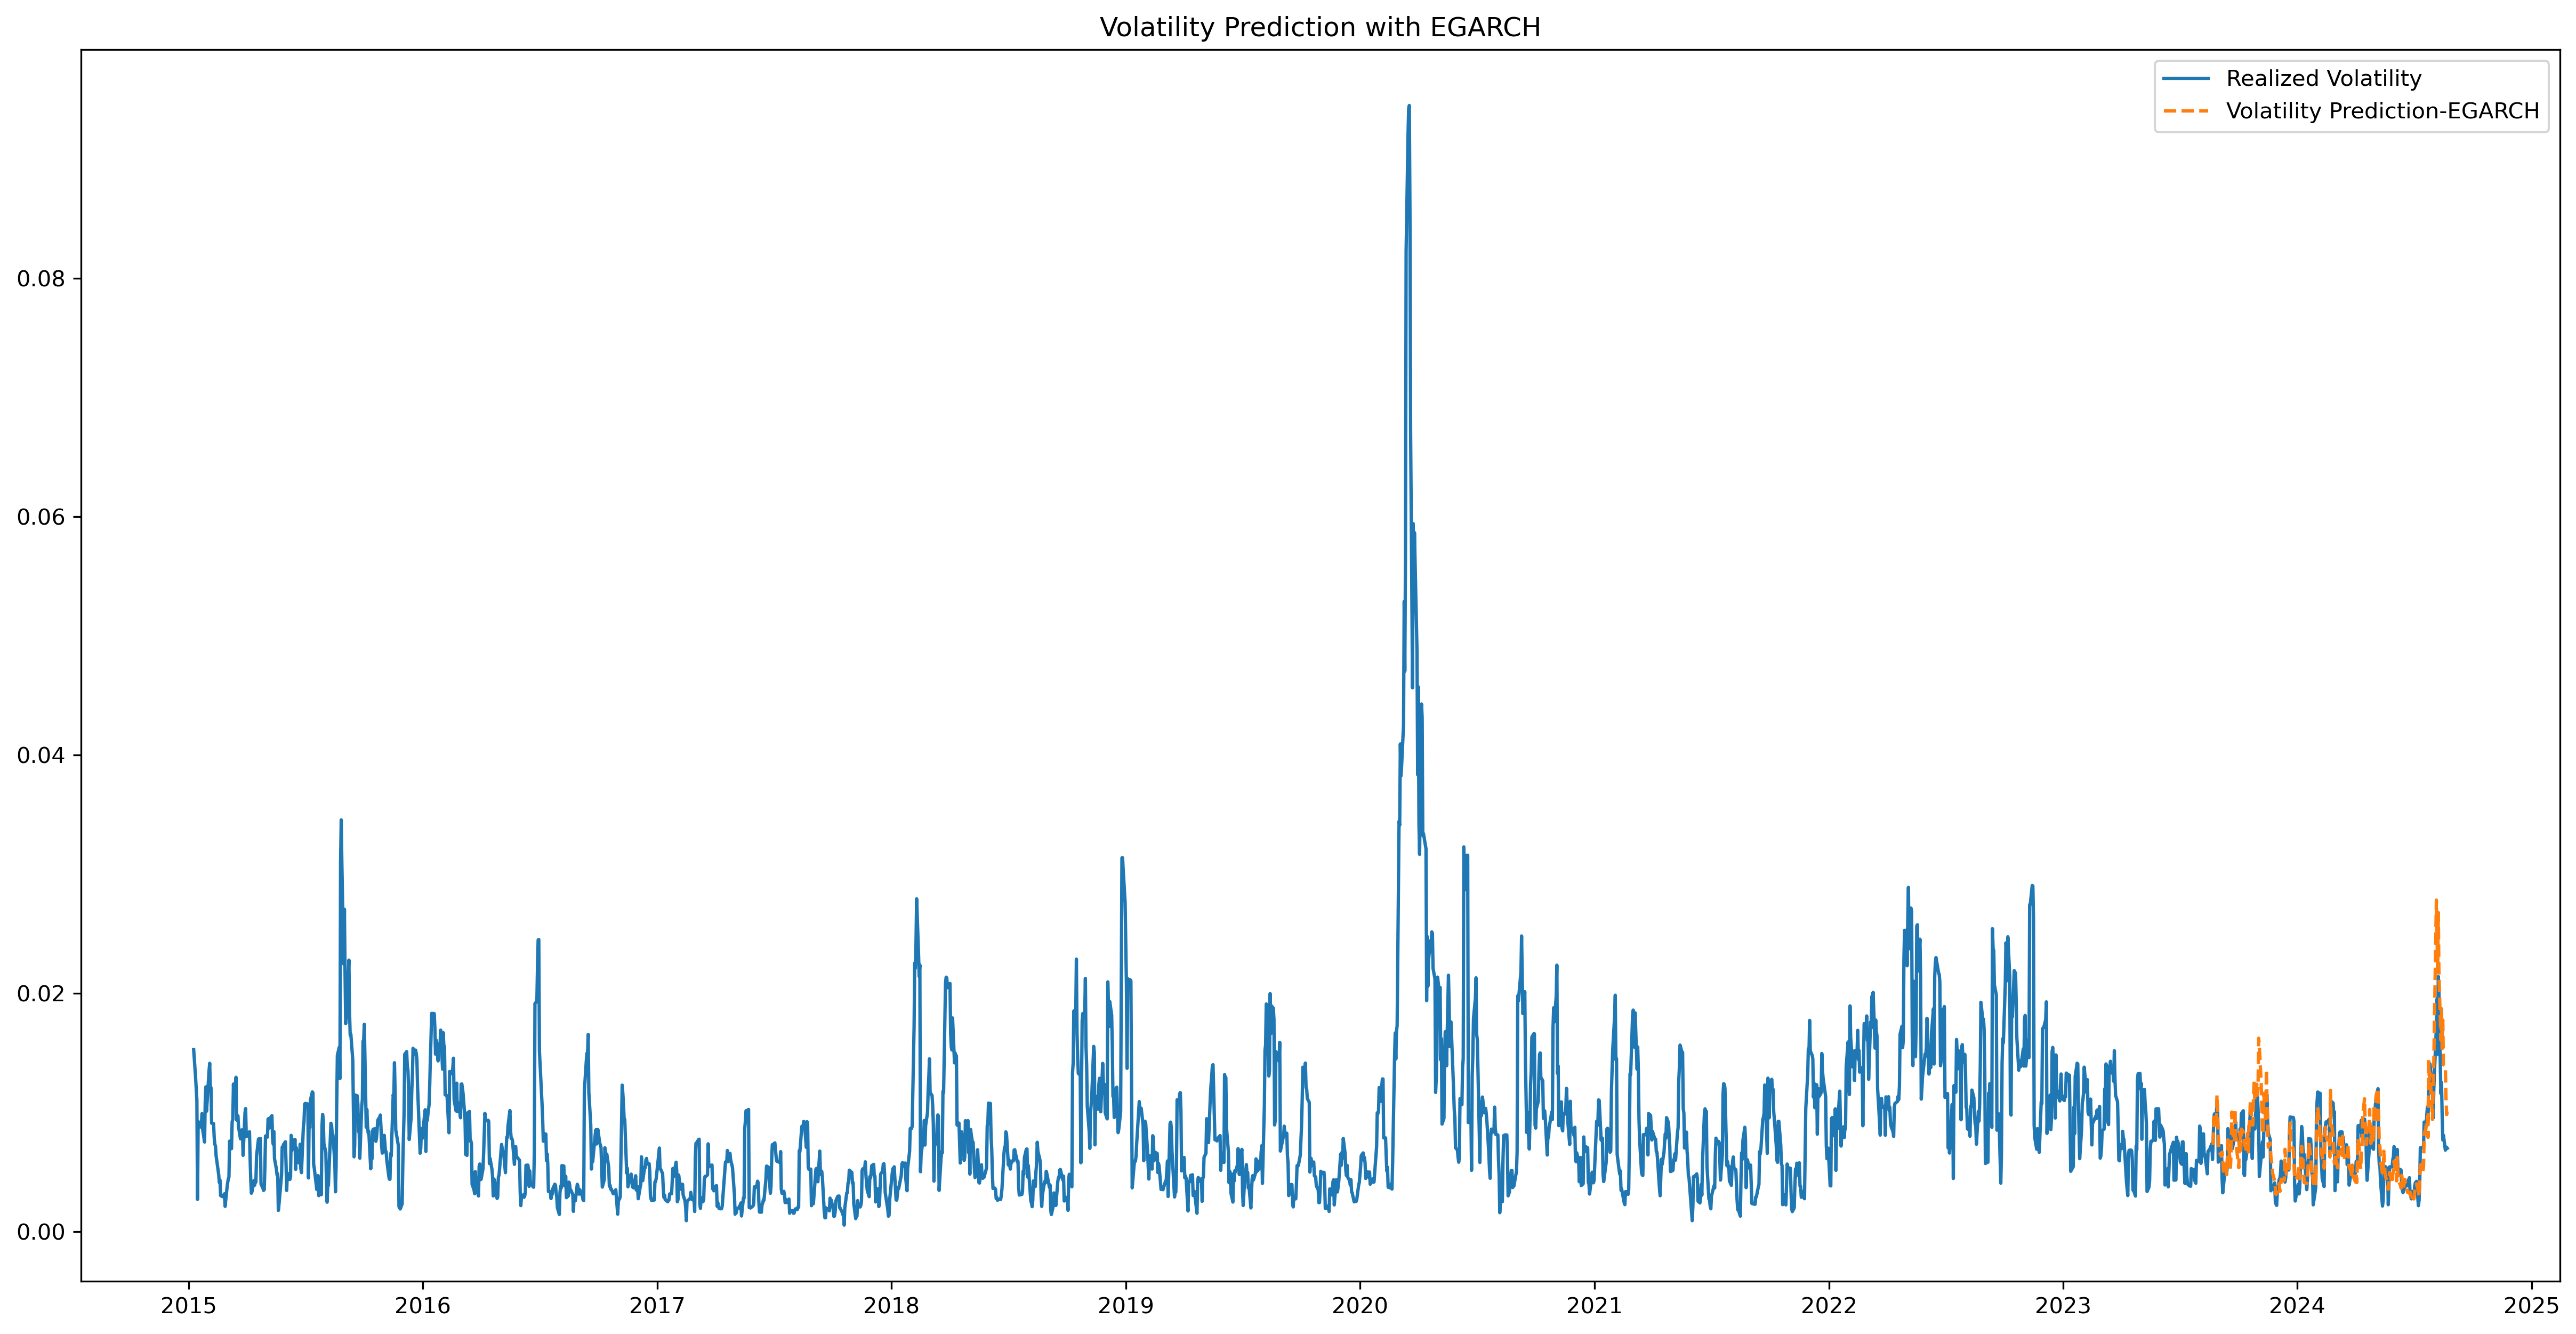

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH', linestyle='--')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

## Machine Learning Models

In [19]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.rename(columns={'Adj Close': 'realized_vol'}, inplace=True)

realized_vol
Date                    
2015-01-05           NaN
2015-01-06           NaN
2015-01-07           NaN
2015-01-08           NaN
2015-01-09      1.526198
...                  ...
2024-08-16      0.807831
2024-08-19      0.682739
2024-08-20      0.709030
2024-08-21      0.706169
2024-08-22      0.698429

[2425 rows x 1 columns]

In [20]:
realized_vol.reset_index(drop=True, inplace=True)

In [21]:
returns_power = ret ** 2
returns_power = pd.DataFrame(returns_power)
returns_power.rename(columns={'Adj Close': 'returns_svm'}, inplace=True)
returns_power = returns_power.reset_index(drop=True)

In [22]:
for lag in range(1, 6):
    realized_vol[f'realized_vol_lag{lag}'] = realized_vol['realized_vol'].shift(lag)
    returns_power[f'returns_svm_lag{lag}'] = returns_power['returns_svm'].shift(lag)

In [23]:
X = pd.concat([realized_vol.iloc[9:], returns_power.iloc[9:]], axis=1, ignore_index=False)

In [24]:
returns_power

returns_svm  returns_svm_lag1  returns_svm_lag2  returns_svm_lag3  \
0        3.340891               NaN               NaN               NaN   
1        0.790938          3.340891               NaN               NaN   
2        1.352532          0.790938          3.340891               NaN   
3        3.199906          1.352532          0.790938          3.340891   
4        0.706240          3.199906          1.352532          0.790938   
...           ...               ...               ...               ...   
2420     0.039592          2.602817          0.146209          2.838409   
2421     0.945228          0.039592          2.602817          0.146209   
2422     0.039385          0.945228          0.039592          2.602817   
2423     0.179749          0.039385          0.945228          0.039592   
2424     0.797950          0.179749          0.039385          0.945228   

      returns_svm_lag4  returns_svm_lag5  
0                  NaN               NaN  
1                  NaN               NaN  
2                  NaN               NaN  
3                  NaN               NaN  
4             3.340891               NaN  
...                ...               ...  
2420          0.000019          0.218246  
2421          2.838409          0.000019  
2422          0.146209          2.838409  
2423          2.602817          0.146209  
2424          0.039592          2.602817  

[2425 rows x 6 columns]

#### SVR-Linear¶

In [25]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
svr_lin = SVR(kernel='linear')
clf = RandomizedSearchCV(svr_lin, para_grid, random_state=42)

In [26]:
clf.fit(X.iloc[:-n].values, 
        realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,))

RandomizedSearchCV(estimator=SVR(kernel='linear'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292b6b810>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292b6a290>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292b40150>},
                   random_state=42)

In [27]:
predict_svr_lin = clf.predict(X.iloc[-n:])
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [28]:
rmse_svr = np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000622


In [29]:
realized_vol.index = ret.index

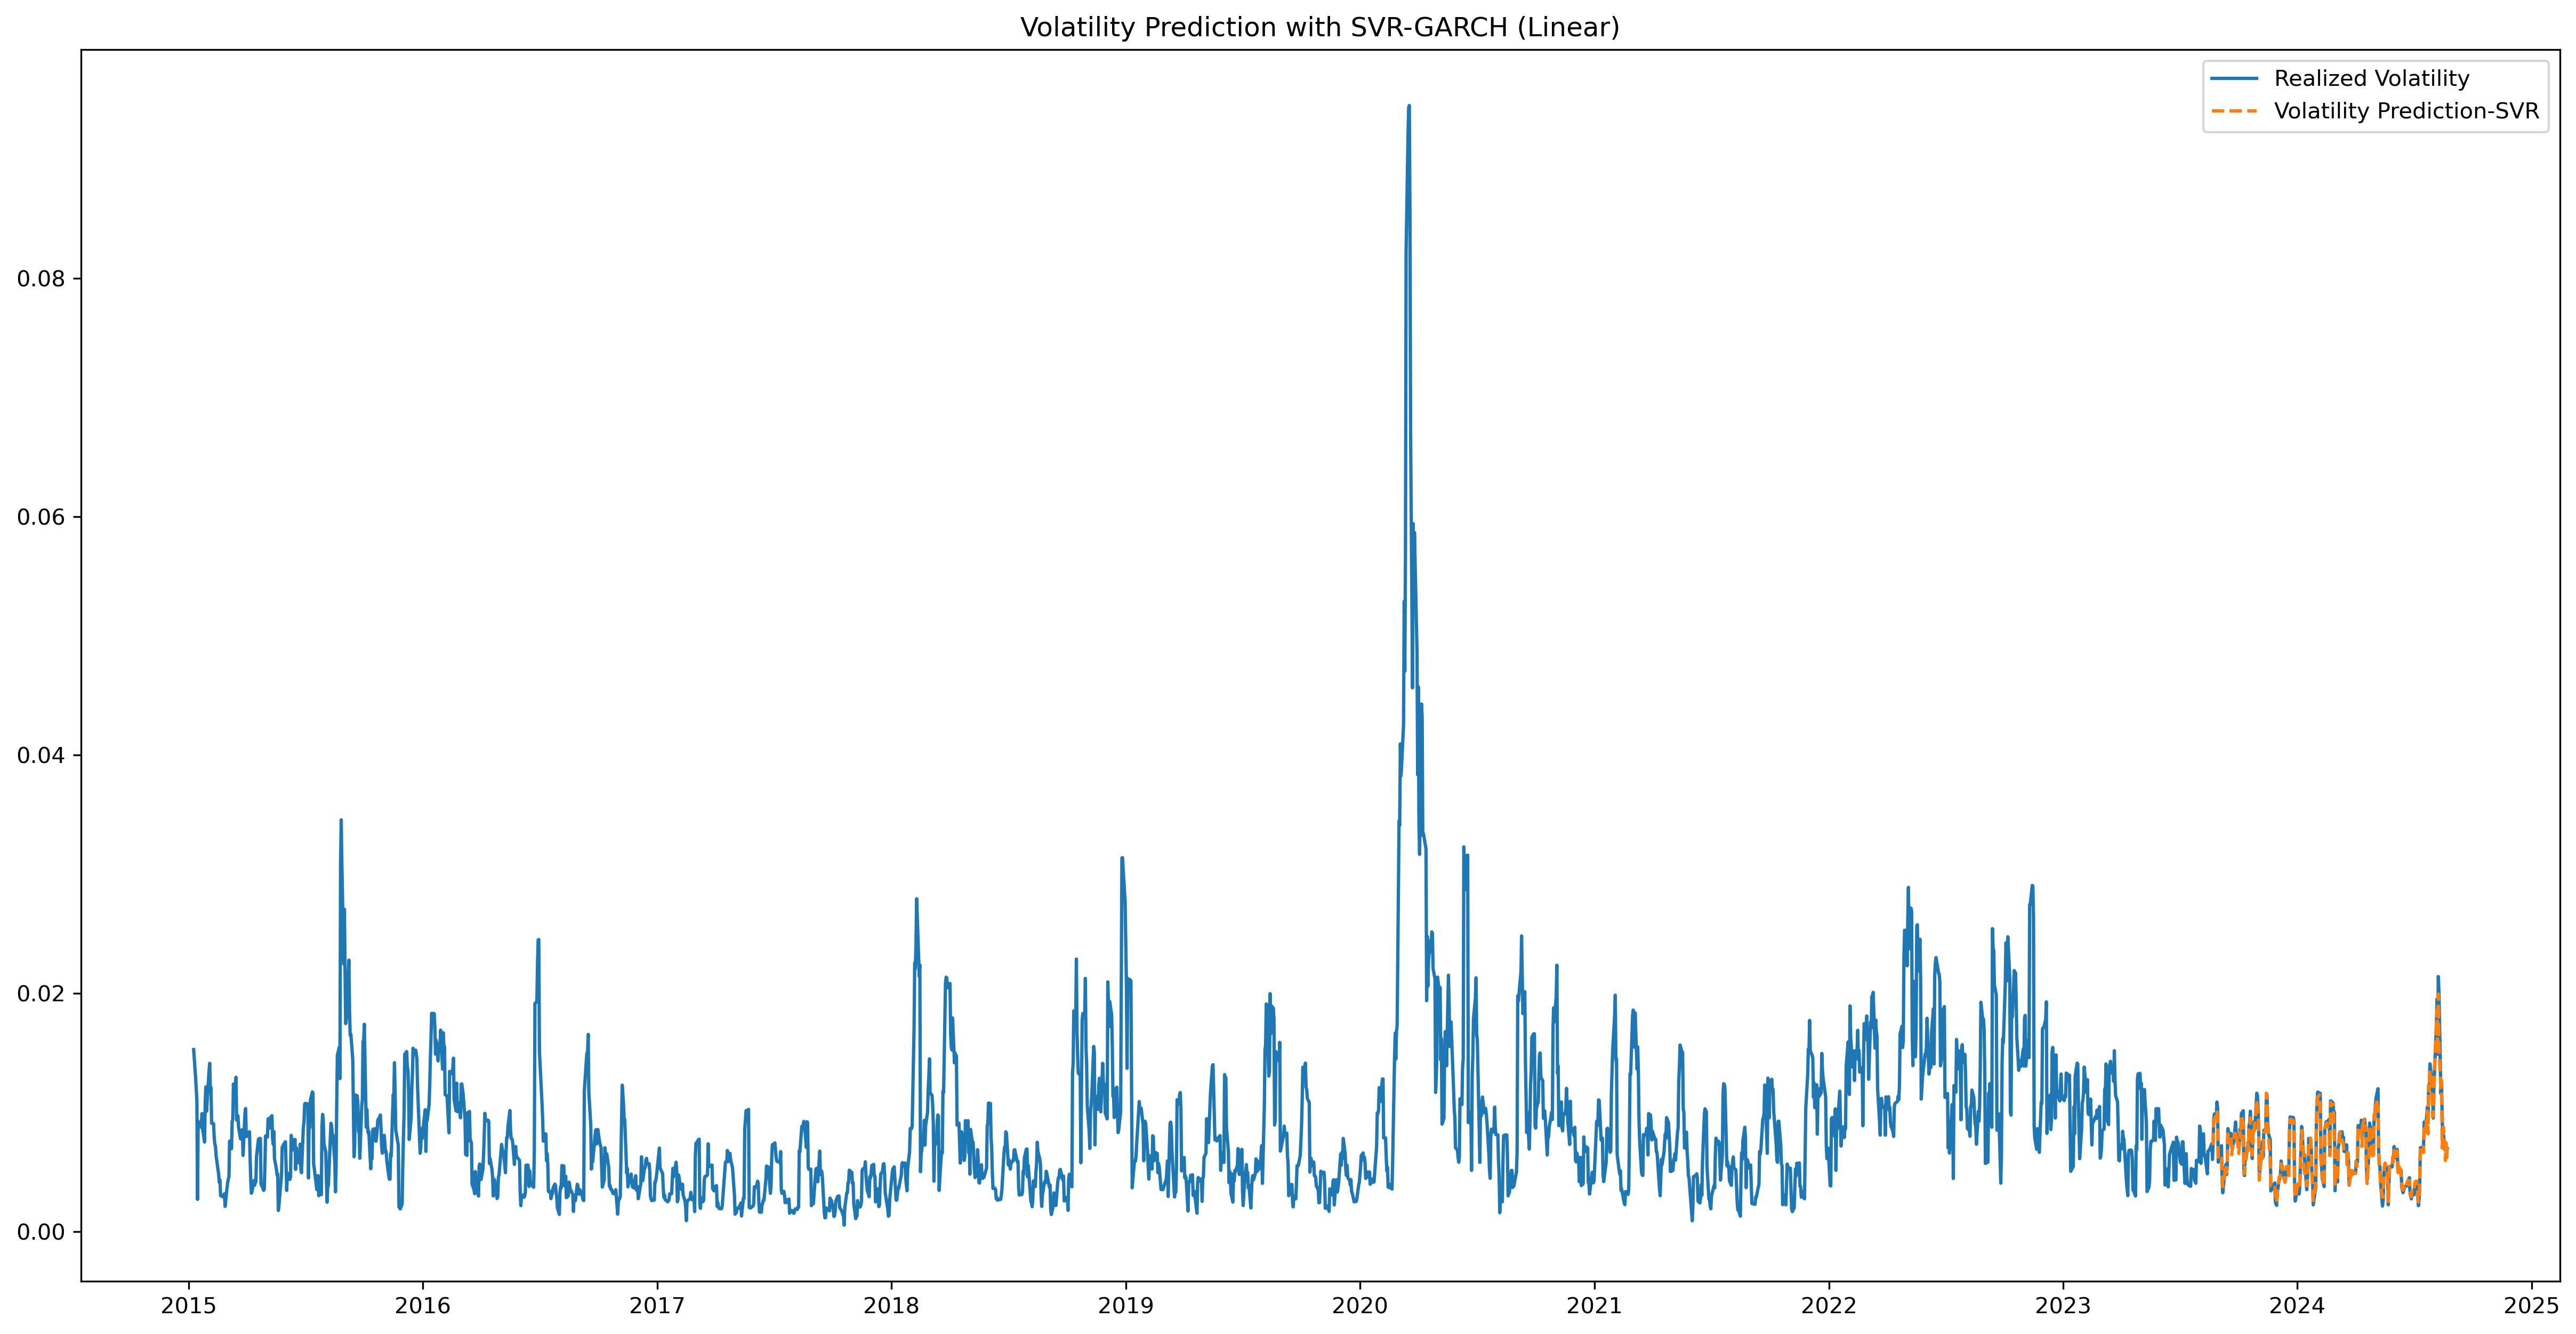

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR', linestyle='--')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

#### SVR-RBF

In [33]:
para_grid ={'gamma': sp_rand(),
            'C': sp_rand(),
            'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid,random_state=42)
clf.fit(X.iloc[:-n].values, 
        realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,))

RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292beb650>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292b354d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x292c50bd0>},
                   random_state=42)

In [34]:
predict_svr_rbf = clf.predict(X.iloc[-n:])
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [35]:
rmse_svr_rbf = np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.001522


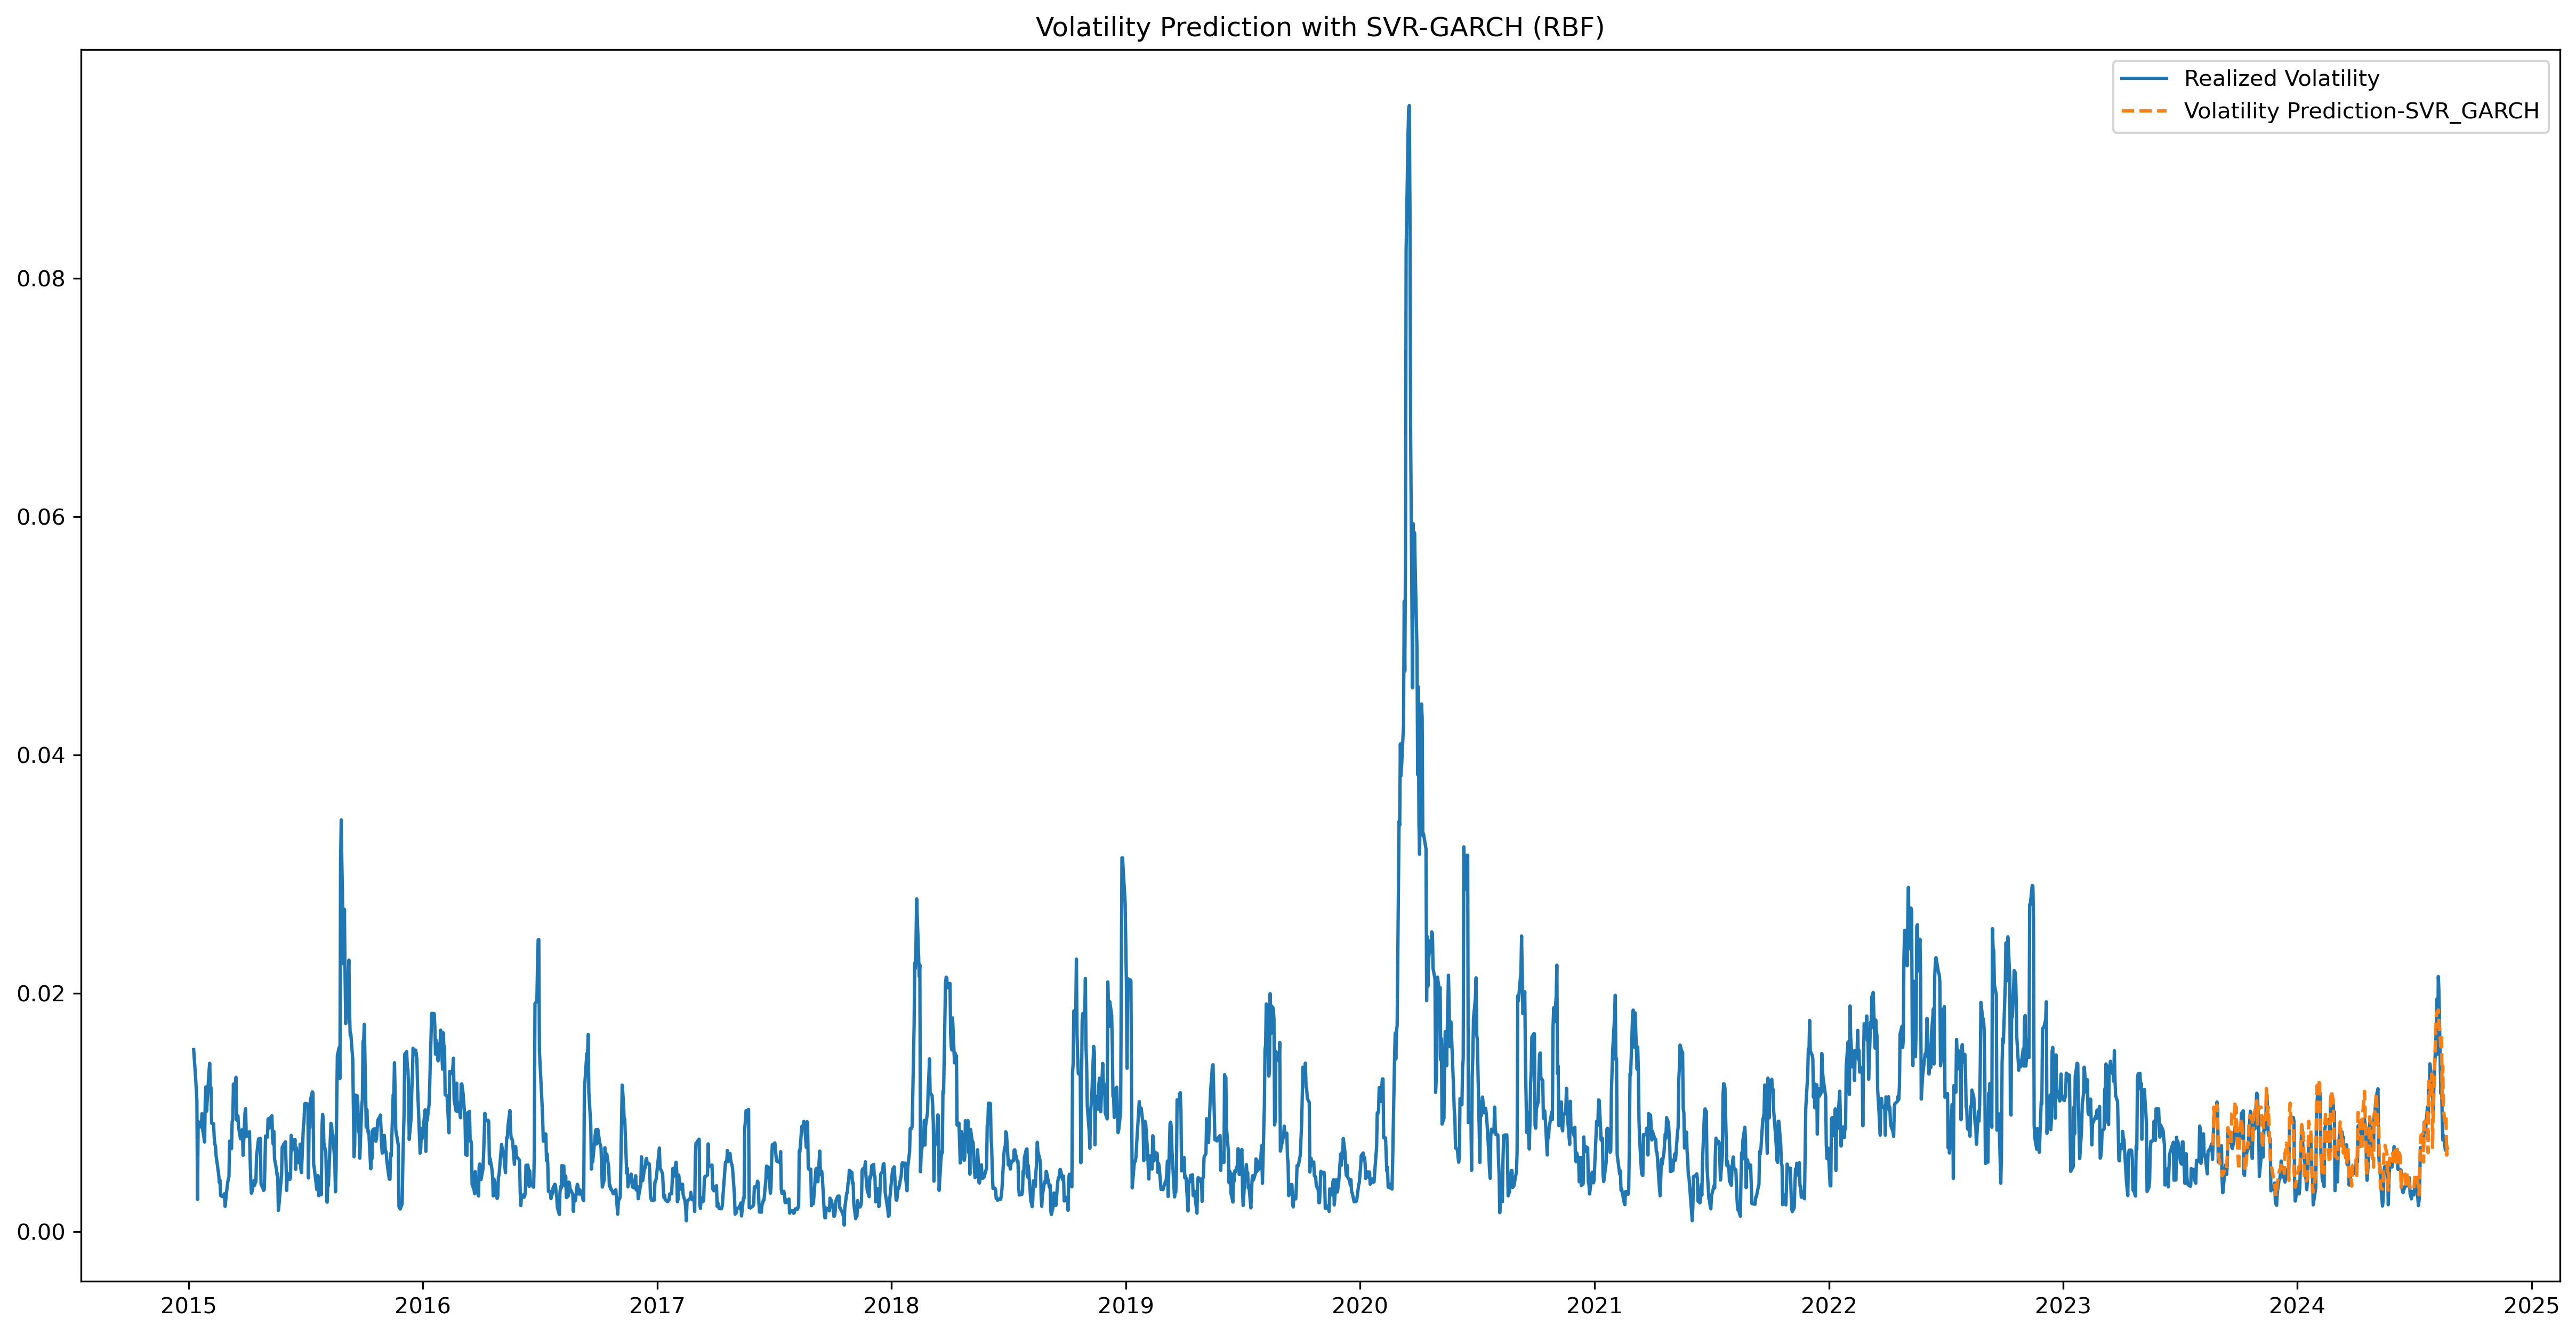

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH', linestyle='--')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

 #### Linear Regression

In [37]:
lin_reg = LinearRegression()

In [38]:
lin_reg.fit(X.iloc[:-n].values, realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,))

LinearRegression()

In [39]:
predict_lin_reg = lin_reg.predict(X.iloc[-n:])
predict_lin_reg = pd.DataFrame(predict_lin_reg, index=ret.iloc[-n:].index)

In [40]:
rmse_lin_reg = np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100, predict_lin_reg.values / 100))
print('The RMSE value of Linear Regression is {:.6f}'.format(rmse_lin_reg))

The RMSE value of Linear Regression is 0.000596


In [41]:
realized_vol.index = ret.index

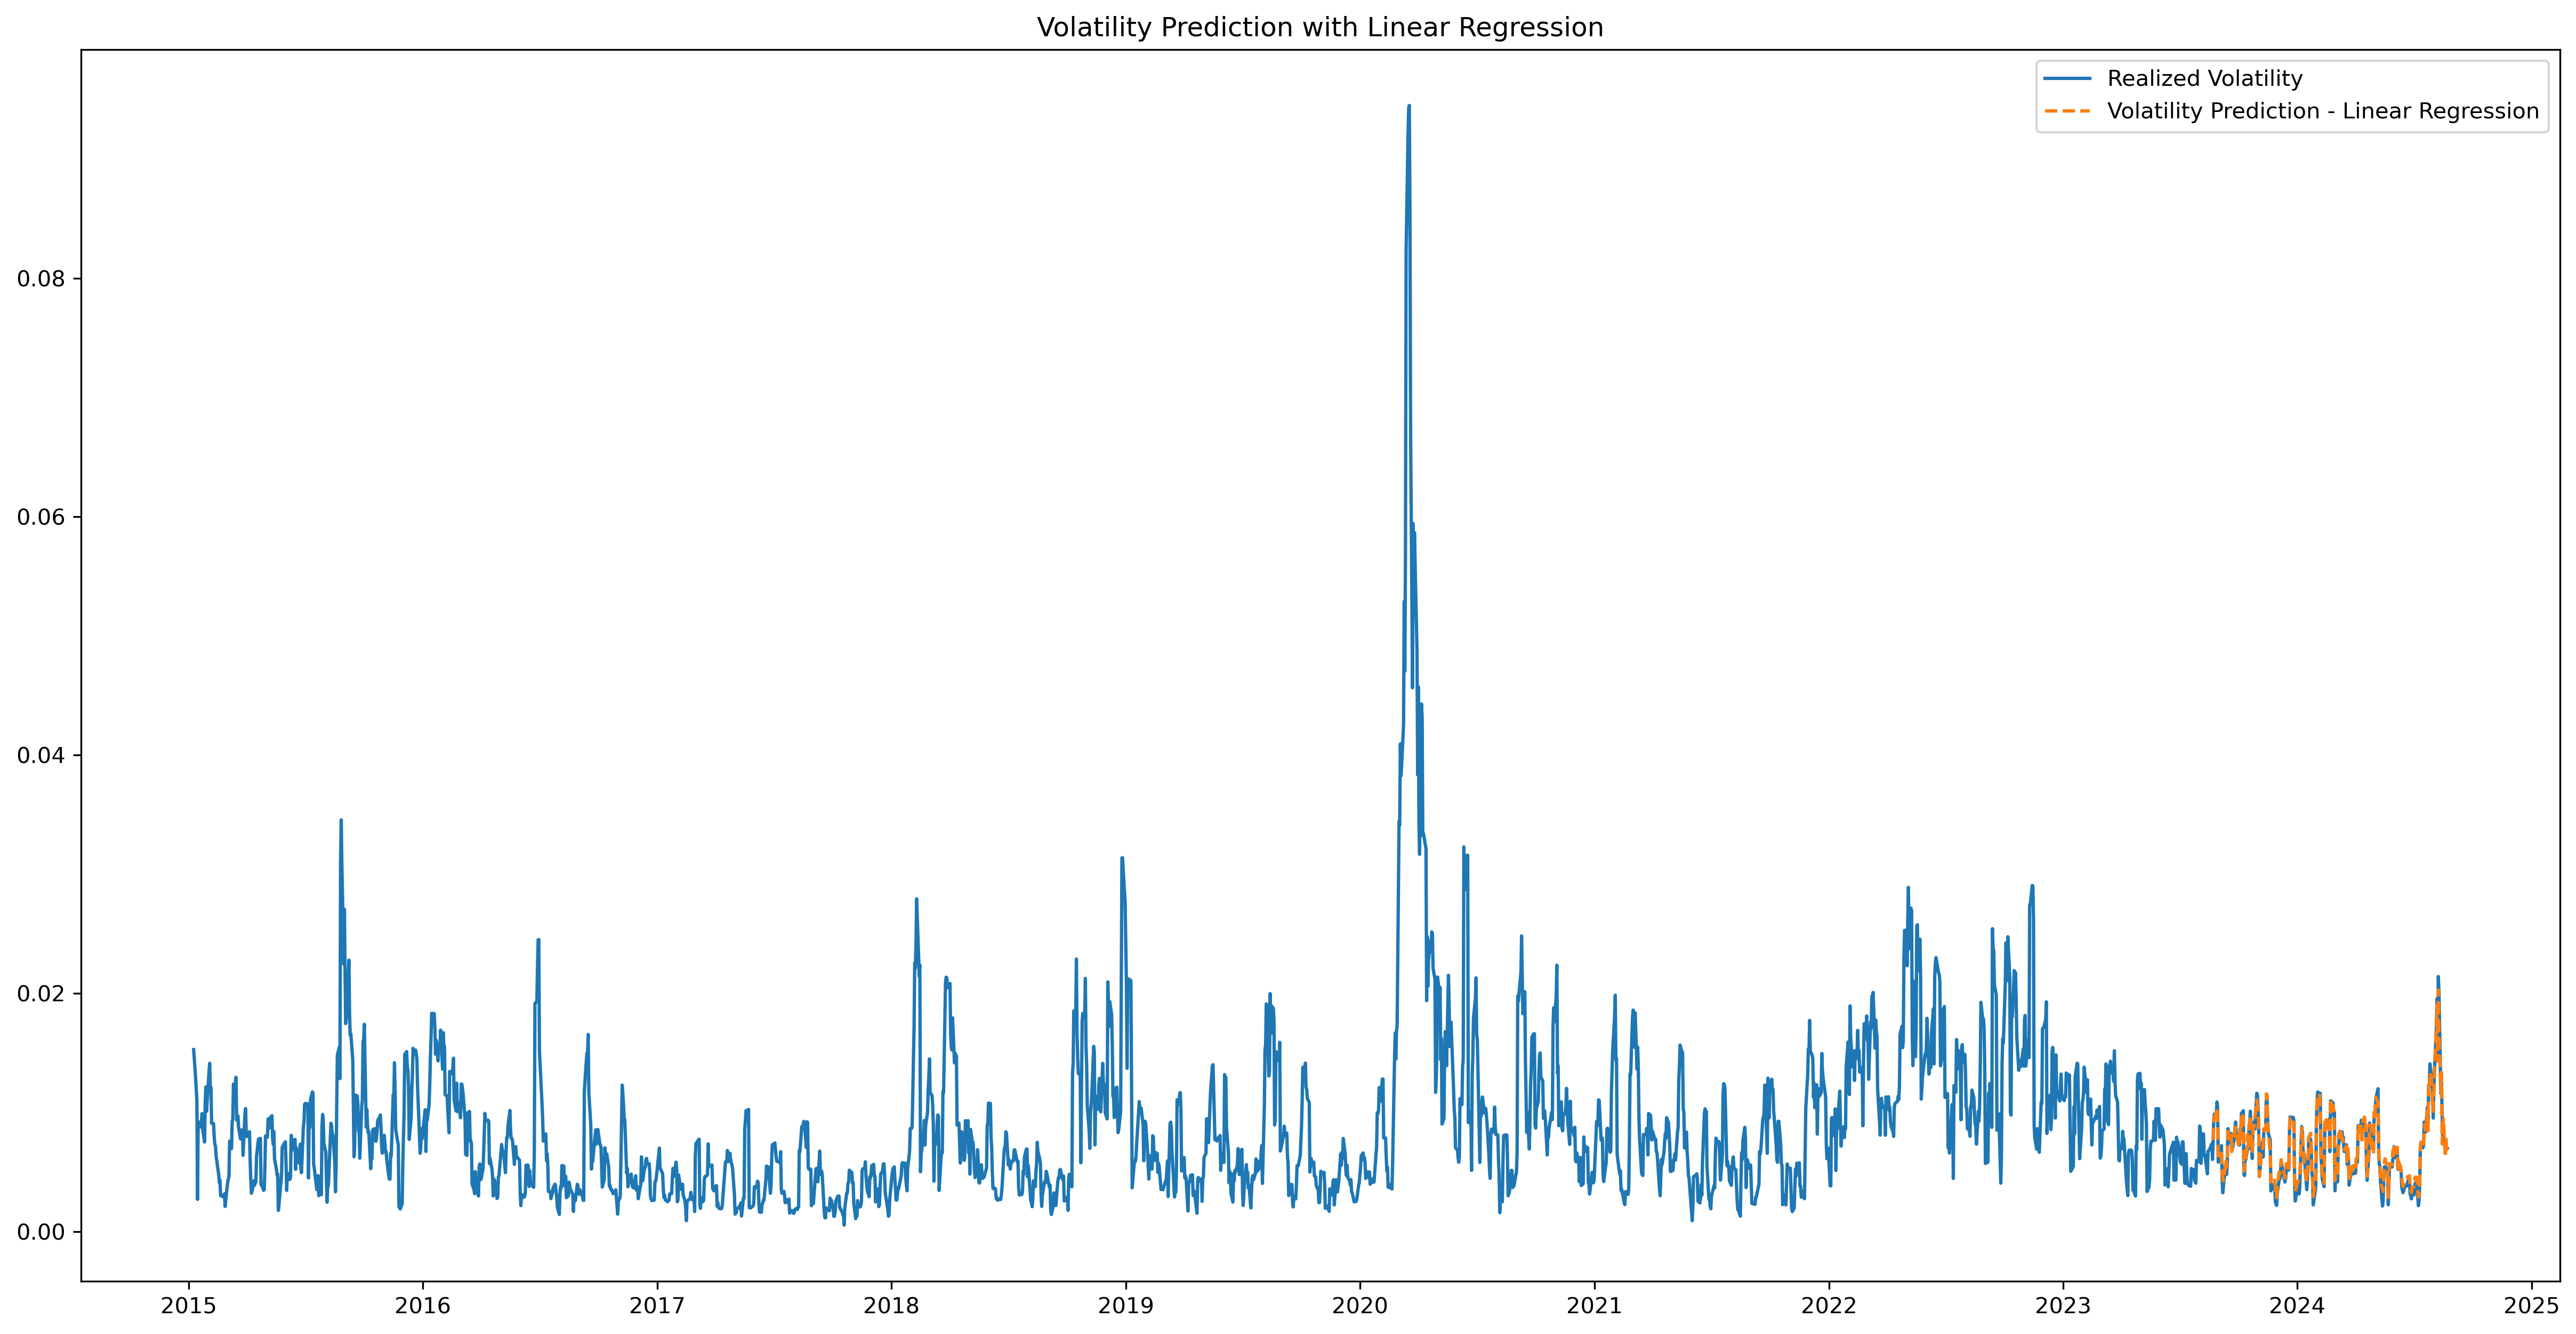

In [42]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(predict_lin_reg / 100, label='Volatility Prediction - Linear Regression', linestyle='--')
plt.title('Volatility Prediction with Linear Regression', fontsize=12)
plt.legend()
plt.show()

#### Deep Learning

In [43]:
model = keras.Sequential()

# Add layers using model.add()
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop')

In [44]:
np.arange(100, 400, 4)

array([100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148,
       152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200,
       204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252,
       256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304,
       308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356,
       360, 364, 368, 372, 376, 380, 384, 388, 392, 396])

In [47]:
epochs_trial = np.arange(100, 1000, 10)
batch_trial = np.arange(100, 400, 10)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(10), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100,
                            DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

8/8 [==============================] - 0s 365us/step
DL_RMSE_1:0.001664
8/8 [==============================] - 0s 462us/step
DL_RMSE_2:0.001693
8/8 [==============================] - 0s 385us/step
DL_RMSE_3:0.001913
8/8 [==============================] - 0s 350us/step
DL_RMSE_4:0.001768
8/8 [==============================] - 0s 366us/step
DL_RMSE_5:0.001772
8/8 [==============================] - 0s 358us/step
DL_RMSE_6:0.001776
8/8 [==============================] - 0s 367us/step
DL_RMSE_7:0.001824
8/8 [==============================] - 0s 362us/step
DL_RMSE_8:0.001781
8/8 [==============================] - 0s 371us/step
DL_RMSE_9:0.001848
8/8 [==============================] - 0s 378us/step
DL_RMSE_10:0.001826


In [48]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

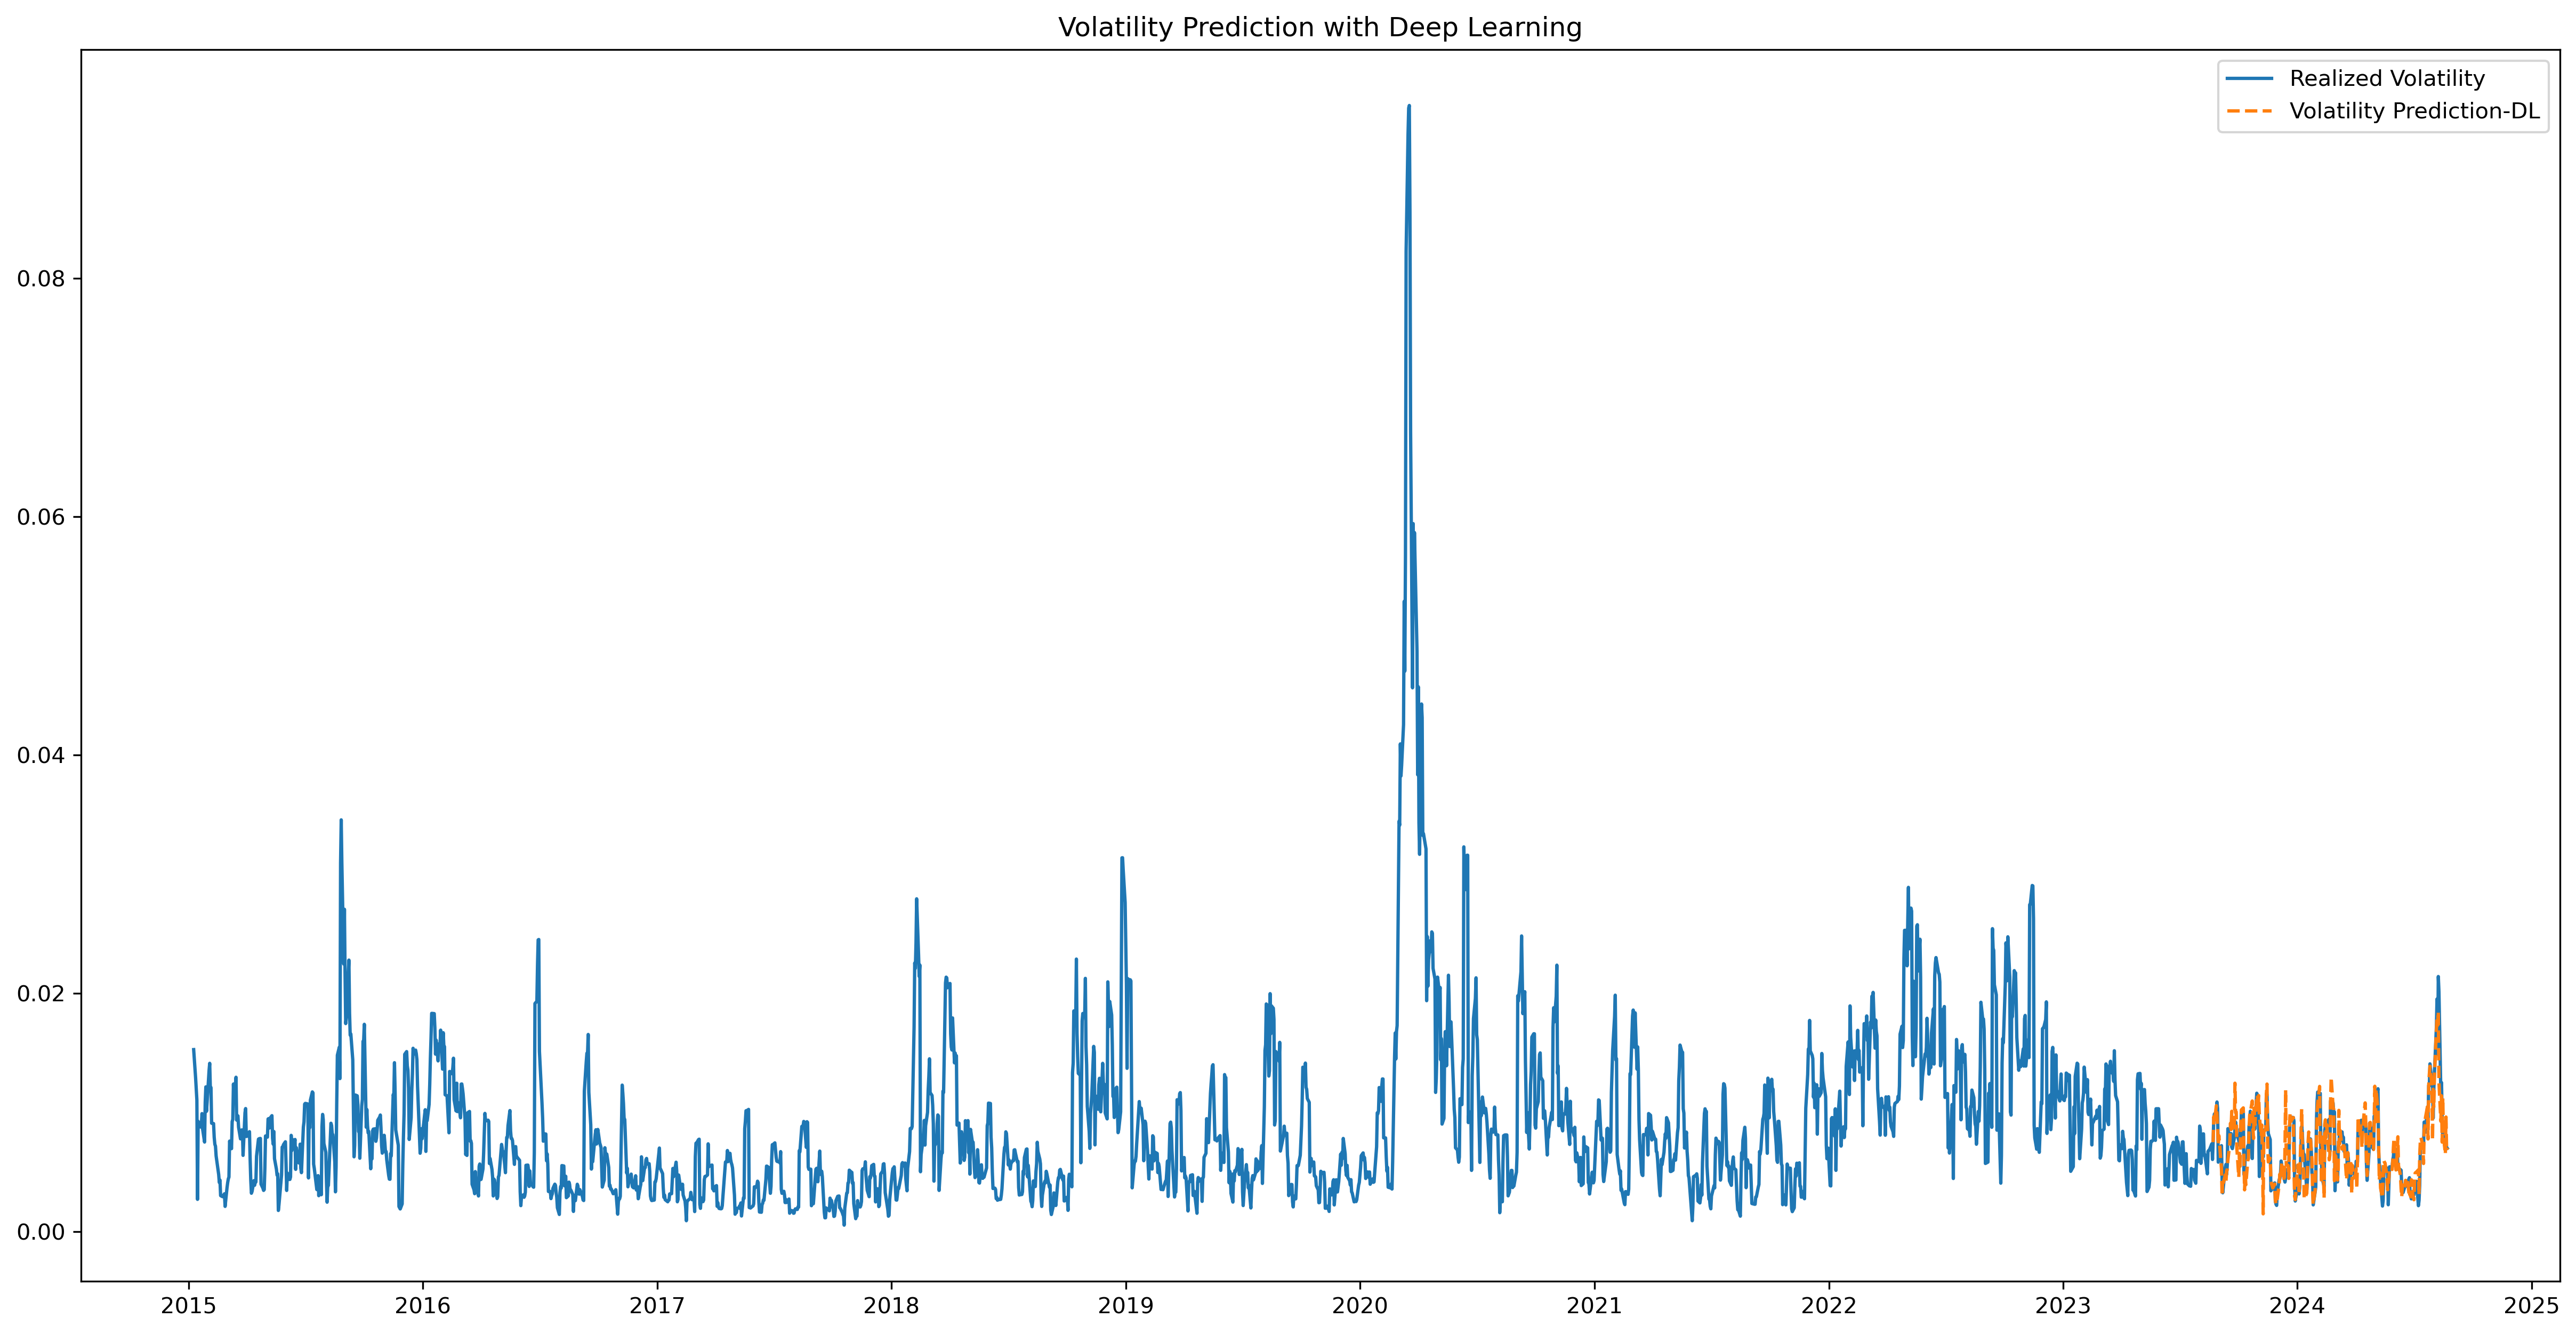

In [49]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL',linestyle='--')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

### Summary

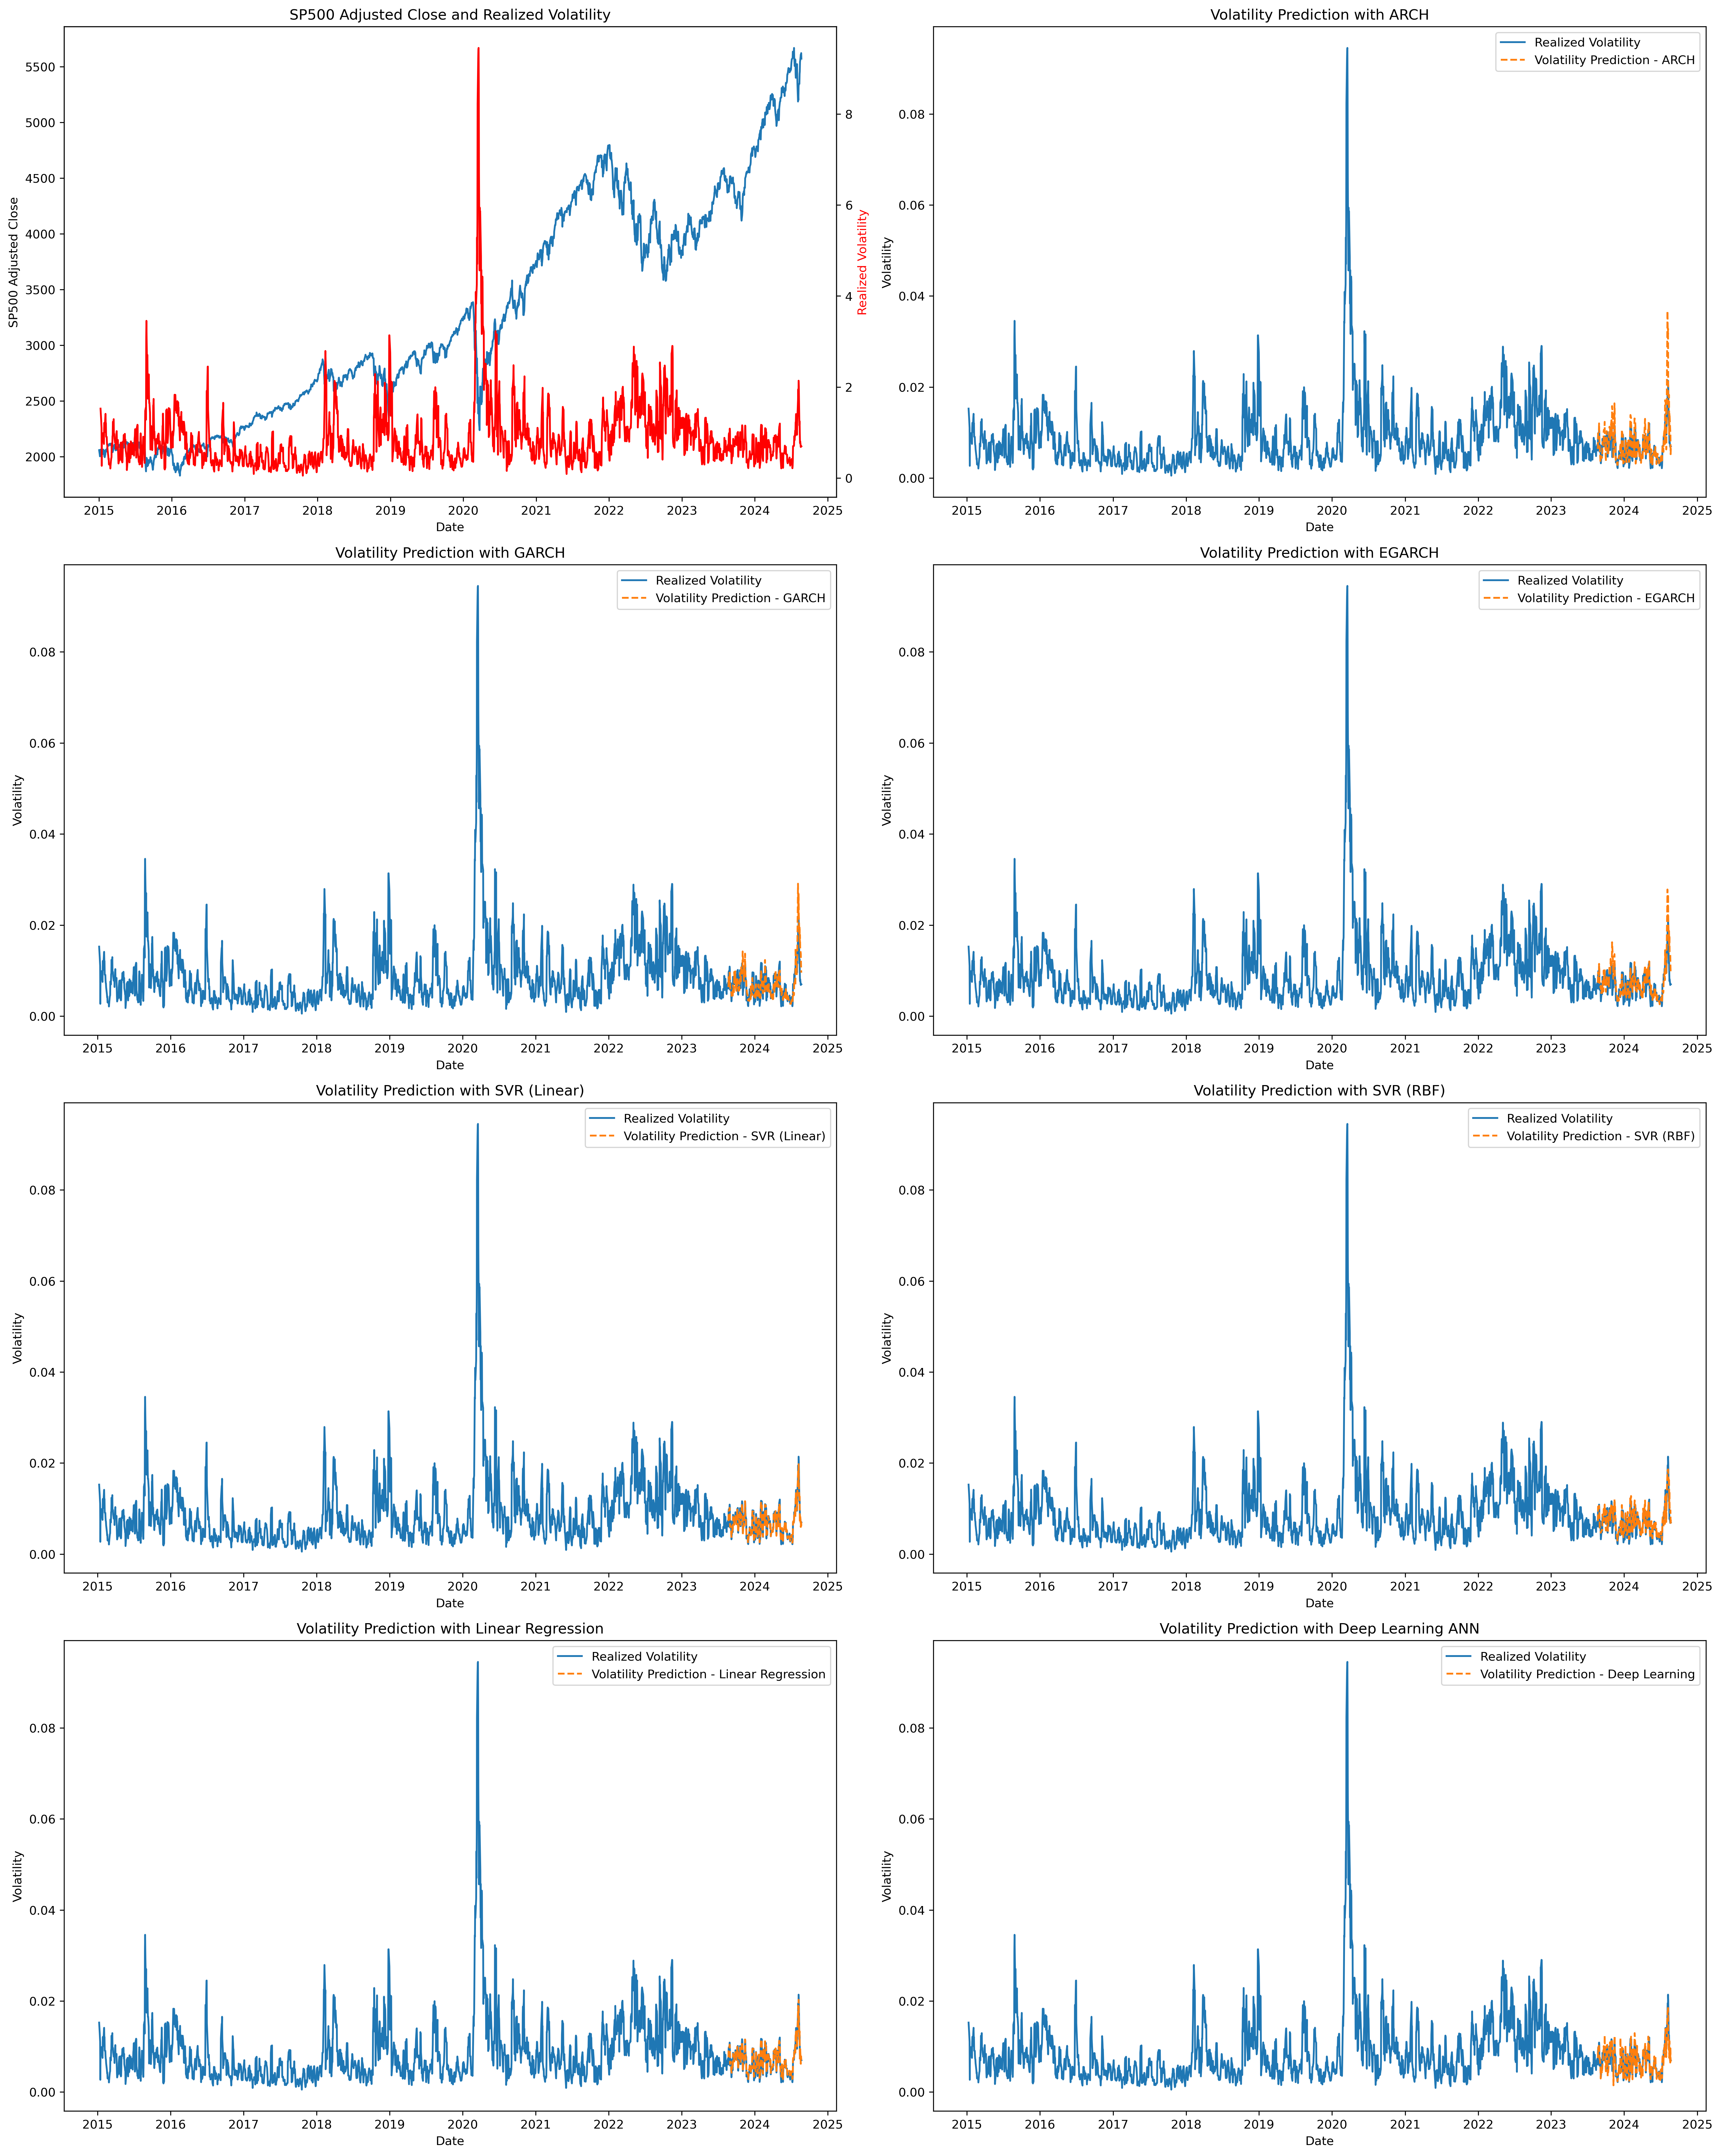

In [51]:
# Define the number of subplots 
fig, axs = plt.subplots(4, 2, figsize=(20, 25))  # Adjusted to 5 rows

# Plot 1 and Plot 2 combined: SP500 Adjusted Close and Realized Volatility on the same plot with different y-axes
axs1 = axs[0, 0]
axs1.plot(s_p500['Adj Close'].index, s_p500['Adj Close'])
axs1.set_ylabel('SP500 Adjusted Close')
axs1.set_xlabel('Date')
axs1.set_title('SP500 Adjusted Close and Realized Volatility')

# Create a twin axis for realized volatility
axs2 = axs1.twinx()
axs2.plot(realized_vol.index, realized_vol['realized_vol'], color='red')
axs2.set_ylabel('Realized Volatility', color='red')

# ARCH Volatility Prediction
axs[0, 1].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[0, 1].plot(forecast_arch.variance.iloc[-len(split_date):].index, 
               forecast_arch.variance.iloc[-len(split_date):] / 100, 
               label='Volatility Prediction - ARCH', linestyle='--')
axs[0, 1].set_title('Volatility Prediction with ARCH')
axs[0, 1].legend()
axs[0, 1].set_ylabel('Volatility')
axs[0, 1].set_xlabel('Date')

# GARCH Volatility Prediction
axs[1, 0].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[1, 0].plot(forecast_garch.variance.iloc[-len(split_date):].index, 
               forecast_garch.variance.iloc[-len(split_date):] / 100, 
               label='Volatility Prediction - GARCH', linestyle='--')
axs[1, 0].set_title('Volatility Prediction with GARCH')
axs[1, 0].legend()
axs[1, 0].set_ylabel('Volatility')
axs[1, 0].set_xlabel('Date')

# EGARCH Volatility Prediction
axs[1, 1].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[1, 1].plot(forecast_egarch.variance.iloc[-len(split_date):].index, 
               forecast_egarch.variance.iloc[-len(split_date):] / 100, 
               label='Volatility Prediction - EGARCH', linestyle='--')
axs[1, 1].set_title('Volatility Prediction with EGARCH')
axs[1, 1].legend()
axs[1, 1].set_ylabel('Volatility')
axs[1, 1].set_xlabel('Date')

# SVR (Linear Kernel)
axs[2, 0].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[2, 0].plot(predict_svr_lin.index, predict_svr_lin / 100, 
               label='Volatility Prediction - SVR (Linear)', linestyle='--')
axs[2, 0].set_title('Volatility Prediction with SVR (Linear)')
axs[2, 0].legend()
axs[2, 0].set_ylabel('Volatility')
axs[2, 0].set_xlabel('Date')

# SVR (RBF Kernel)
axs[2, 1].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[2, 1].plot(predict_svr_rbf.index, predict_svr_rbf / 100, 
               label='Volatility Prediction - SVR (RBF)', linestyle='--')
axs[2, 1].set_title('Volatility Prediction with SVR (RBF)')
axs[2, 1].legend()
axs[2, 1].set_ylabel('Volatility')
axs[2, 1].set_xlabel('Date')

# Linear Regression
axs[3, 0].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[3, 0].plot(predict_lin_reg.index, predict_lin_reg / 100, 
               label='Volatility Prediction - Linear Regression', linestyle='--')
axs[3, 0].set_title('Volatility Prediction with Linear Regression')
axs[3, 0].legend()
axs[3, 0].set_ylabel('Volatility')
axs[3, 0].set_xlabel('Date')

# Deep Learning Volatility Prediction
axs[3, 1].plot(realized_vol.index, realized_vol['realized_vol'] / 100, label='Realized Volatility')
axs[3, 1].plot(DL_predict.index, DL_predict / 100, 
               label='Volatility Prediction - Deep Learning', linestyle='--')
axs[3, 1].set_title('Volatility Prediction with Deep Learning ANN')
axs[3, 1].legend()
axs[3, 1].set_ylabel('Volatility')
axs[3, 1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Save the figure to a file
plt.savefig("volatility_predictions.png", dpi=200)

plt.show()
